<a href="https://colab.research.google.com/github/vaishvenumich/IBD_risk/blob/main/Final_Code%E2%80%93SI_670_Applied_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Inflammatory Bowel Disease (IBD) Using National Health Interview Survey (NHIS) Data (2023-2024)**

## **Data Loading and Cleaning**


### **Loading Libraries**

In [1]:
!pip install imblearn
!pip install xgboost
!pip install umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, recall_score, make_scorer, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier

import scipy.stats as stats
import umap

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


### **Mounting Google Drive and Loading Data**

We first mount Google Drive and load two NHIS Sample Adult datasets:

* **adult23.csv** (2023 survey)
* **adult24.csv** (2024 survey)

These datasets are read into Pandas dataframes and then **vertically concatenated** into a single dataframe called `combined_df`. This allows us to work with both years of survey responses as one unified dataset.


In [2]:
from google.colab import drive
drive.mount('/content/drive') # uncomment if running locally

Mounted at /content/drive


In [3]:
# Define the base path to the data files
data_path = '/content/drive/MyDrive/670_Project/data/' # Note to 670 team: change accordingly if you are running locally

# Load adult23.csv
adult23_df = pd.read_csv(f'{data_path}adult23.csv')

# Load adult24.csv
adult24_df = pd.read_csv(f'{data_path}adult24.csv')

# Combine the two dataframes
combined_df = pd.concat([adult23_df, adult24_df], ignore_index=True)

# Display the first 5 rows of the combined dataframe
display(combined_df.head())

,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,LANGSPECR_A,LANGSOC_A,LANGDOC_A,LANGMED_A,LANGHM_A,PPSU,...,DXFOOD_A,CURFOOD_A,DXRESP_A,CURRESP_A,DRYMTH12M_A,COLDFLU12M_A,LIVEREV_A,KIDWEAKEV_A,DIBGLP_A,AVGNUMCIG_A
0,3.0,4,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,8,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,14,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,10,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,5,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Creating the `IBDSEV_A` Indicator Variable**

The NHIS contains two variables related to inflammatory bowel disease (IBD) severity:

* **ULCCOLEV_A** — Indicates severe ulcerative colitis
* **CROHNSEV_A** — Indicates severe Crohn’s disease

To identify whether a respondent has **severe IBD of any type**, we create a new binary variable:

* If the respondent has **either** severe ulcerative colitis **or** severe Crohn’s disease → `IBDSEV_A = 1`
* Otherwise → `IBDSEV_A = 0`

This gives a unified indicator of severe IBD across both conditions.

In [4]:
# Create the new column IBDSEV_A based on the conditions
combined_df['IBDSEV_A'] = ((combined_df['ULCCOLEV_A'] == 1) | (combined_df['CROHNSEV_A'] == 1)).astype(int)

# Display the relevant columns to verify the new column
display(combined_df[['ULCCOLEV_A', 'CROHNSEV_A', 'IBDSEV_A']].head())

/tmp/ipython-input-3617851111.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['IBDSEV_A'] = ((combined_df['ULCCOLEV_A'] == 1) | (combined_df['CROHNSEV_A'] == 1)).astype(int)


,ULCCOLEV_A,CROHNSEV_A,IBDSEV_A
0,2,2,0
1,2,2,0
2,2,2,0
3,2,2,0
4,2,2,0


### **Dropping Redundant Columns**

After creating the combined indicator, the original columns:

* `ULCCOLEV_A`
* `CROHNSEV_A`

This is done to: Avoid multicollinearity, reduce unnecessary features, and to keep the dataset clean, with a single variable representing severe IBD status

In [5]:
combined_df.drop(columns=['ULCCOLEV_A', 'CROHNSEV_A'], inplace=True)

# Display the first 5 rows of the combined dataframe to verify the columns are dropped
display(combined_df.head())

,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,LANGSPECR_A,LANGSOC_A,LANGDOC_A,LANGMED_A,LANGHM_A,PPSU,...,CURFOOD_A,DXRESP_A,CURRESP_A,DRYMTH12M_A,COLDFLU12M_A,LIVEREV_A,KIDWEAKEV_A,DIBGLP_A,AVGNUMCIG_A,IBDSEV_A
0,3.0,4,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,4.0,8,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4.0,14,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4.0,10,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4.0,5,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### **Identify Useable Columns**

In the **NHIS Sample Adult Survey**, many variables follow a common categorical coding scheme. Although these variables are not strictly binary, they behave like *binary questions with additional non-substantive response codes*.

Most questions in the NHIS questionnaire structure uses the following standardized codes:

| Code  | Meaning         |
| ----- | --------------- |
| **1** | Yes             |
| **2** | No              |
| **7** | Refused         |
| **8** | Not Ascertained |
| **9** | Don't Know      |

Columns containing values outside of the set {1, 2, 7, 8, 9} were excluded to maintain simplicity and interpretability in the analysis. Aside from basic information of the sample adult (Background, Geographical background, etc.), many of these variables capture administrative/metadata fields that do not provide direct information about the presence or severity of IBD. Including them could introduce noise or irrelevant variation into the analysis.


In [6]:
# Get a list of all numeric columns from the combined_df DataFrame.
numeric_cols = combined_df.select_dtypes(include=np.number).columns.tolist()

# Exclude 'IBDSEV_A' if it's in the numeric columns, as it's our target.
if 'IBDSEV_A' in numeric_cols:
    numeric_cols.remove('IBDSEV_A')

# Initialize a list to store identified binary-like columns.
binary_like_cols = []

# Define the set of values that constitute 'binary-like' for this task
# This includes 1, 2, and other codes often used for 'refused', 'unknown', etc.
allowed_values = {1.0, 2.0, 7.0, 8.0, 9.0}

# Iterate through each numeric column.
for col in numeric_cols:
    # 4. For each column, get its unique non-NaN values.
    unique_vals = combined_df[col].dropna().unique()

    # Check if all unique values are within the allowed set
    # Also, ensure there are actual unique values to check (i.e., not an empty column after dropping NaNs)
    if len(unique_vals) > 0 and set(unique_vals).issubset(allowed_values):
        binary_like_cols.append(col)

# Print the count and names of the identified binary_like_cols.
print(f"Found {len(binary_like_cols)} binary-like columns based on values {{1, 2, 7, 8, 9}} and NaN:")
print(binary_like_cols)

Found 453 binary-like columns based on values {1, 2, 7, 8, 9} and NaN:
['LANGSPECR_A', 'LANGSOC_A', 'LANGDOC_A', 'LANGMED_A', 'LANGHM_A', 'DISAB3_A', 'AFNOW', 'CITZNSTP_A', 'SASPPRACE_A', 'SASPPHISP_A', 'PRTNRWKFT_A', 'PRTNRWRK_A', 'SPOUSWKFT_A', 'SPOUSWRK_A', 'SPOUSESEX_A', 'PRTNRSEX_A', 'HHRESPSA_FLG', 'EMPWRKFT1_A', 'EMPWRKLSW1_A', 'PHQ2SCREEN_A', 'GAD2SCREEN_A', 'EXCHANGE_A', 'NOTCOV_A', 'MILSPC1R_A', 'OGFLG_A', 'OPFLG_A', 'MAFLG_A', 'RSNHIMISS_A', 'RSNHIJOB_A', 'MCADVR_A', 'PRFLG_A', 'PRPREM1_A', 'PXCHNG1_A', 'IHS_A', 'PRPLCOV1_C_A', 'PRPLCOV2_C_A', 'PLEXCHOG_A', 'PLEXCHOP_A', 'MLTFAMFLG_A', 'OTHERCANP_A', 'COLRCCAN_A', 'HDNCKCAN_A', 'UTERUCAN_A', 'THYROCAN_A', 'THROACAN_A', 'STOMACAN_A', 'SKNDKCAN_A', 'SKNNMCAN_A', 'SKNMCAN_A', 'RECTUCAN_A', 'PROSTCAN_A', 'PANCRCAN_A', 'OVARYCAN_A', 'MOUTHCAN_A', 'MELANCAN_A', 'LYMPHCAN_A', 'LUNGCAN_A', 'LIVERCAN_A', 'LEUKECAN_A', 'LARYNCAN_A', 'GALLBCAN_A', 'ESOPHCAN_A', 'COLONCAN_A', 'CERVICAN_A', 'BREASCAN_A', 'BRAINCAN_A', 'BONECAN_A', 'BLOOD

## **Initial Feature Selection**

### **Splitting the Dataset by Target**
The dataset is divided into two subsets based on the target variable `IBDSEV_A`:

- One subset for individuals with `IBDSEV_A = 0` (No IBD)
- Another subset for individuals with `IBDSEV_A = 1` (IBD)

This allows subsequent calculations to compare feature distributions between the two groups.

In [7]:
ibdsev_0_df = combined_df[combined_df['IBDSEV_A'] == 0]
ibdsev_1_df = combined_df[combined_df['IBDSEV_A'] == 1]

print("First 5 rows of ibdsev_0_df:")
display(ibdsev_0_df.head())
print(f"Shape of ibdsev_0_df: {ibdsev_0_df.shape}")

print("\nFirst 5 rows of ibdsev_1_df:")
display(ibdsev_1_df.head())
print(f"Shape of ibdsev_1_df: {ibdsev_1_df.shape}")

First 5 rows of ibdsev_0_df:


,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,LANGSPECR_A,LANGSOC_A,LANGDOC_A,LANGMED_A,LANGHM_A,PPSU,...,CURFOOD_A,DXRESP_A,CURRESP_A,DRYMTH12M_A,COLDFLU12M_A,LIVEREV_A,KIDWEAKEV_A,DIBGLP_A,AVGNUMCIG_A,IBDSEV_A
0,3.0,4,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,4.0,8,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4.0,14,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4.0,10,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4.0,5,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Shape of ibdsev_0_df: (61025, 783)

First 5 rows of ibdsev_1_df:


,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,LANGSPECR_A,LANGSOC_A,LANGDOC_A,LANGMED_A,LANGHM_A,PPSU,...,CURFOOD_A,DXRESP_A,CURRESP_A,DRYMTH12M_A,COLDFLU12M_A,LIVEREV_A,KIDWEAKEV_A,DIBGLP_A,AVGNUMCIG_A,IBDSEV_A
29,3.0,6,0,0,NaN,NaN,NaN,NaN,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
63,1.0,9,0,0,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
64,1.0,3,0,0,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
72,1.0,14,1,0,NaN,NaN,NaN,NaN,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
79,1.0,14,0,2,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Shape of ibdsev_1_df: (1126, 783)


### **Computing Percentages of "Yes" Responses**
For each candidate binary-like variable:

- The code counts the number of rows equal to `1` in each target group.
- It then converts these counts into percentages relative to the total number of rows in that group (including rows with NaN values).
- This produces a series of percentages for `IBDSEV_A = 0` and another for `IBDSEV_A = 1`.
- The top 20 features by percentage are displayed for both groups to quickly inspect which features are more common in each group.

In [8]:
# Initialize an empty dictionary to store the percentages of '1's for ibdsev_0_df
percentages_of_ones_ibdsev0 = {}

# Total number of rows in ibdsev_0_df
total_rows_ibdsev0 = len(ibdsev_0_df)

# Iterate through each column name in the binary_like_cols list
for col in binary_like_cols:
    # For each column, count the number of rows in ibdsev_0_df where the column's value is '1'.
    count_of_ones = (ibdsev_0_df[col] == 1).sum()

    # Calculate the percentage of '1's
    if total_rows_ibdsev0 > 0:
        percentage = (count_of_ones / total_rows_ibdsev0) * 100
    else:
        percentage = 0.0 # Handle case where ibdsev_0_df might be empty

    # Store this percentage in the dictionary
    percentages_of_ones_ibdsev0[col] = percentage

# Convert the dictionary of percentages to a pandas Series
percentages_series_ibdsev0 = pd.Series(percentages_of_ones_ibdsev0)

# Print the resulting Series, sorted in descending order
print("Percentages of '1's for binary-like variables when IBDSEV_A is '0' (sorted descending):")
display(percentages_series_ibdsev0.sort_values(ascending=False).head(20)) # Display top 20 for a comprehensive view

Percentages of '1's for binary-like variables when IBDSEV_A is '0' (sorted descending):


,0
HHSTAT_A,100.000000
IMPNUM_A,100.000000
HICOV_A,93.610815
ACCSSINT_A,91.560836
CITZNSTP_A,89.433839
ACCSSHOM_A,89.366653
WELLNESS_A,81.386317
NATUSBORN_A,80.247440
SHTCVD191_A,78.462925
RX12M_A,73.115936


In [9]:
# Initialize an empty dictionary to store the percentages of '1's for ibdsev_1_df
percentages_of_ones_ibdsev1 = {}

# Get the total number of rows in ibdsev_1_df
total_rows_ibdsev1 = len(ibdsev_1_df)

# Iterate through each column name in the binary_like_cols list
for col in binary_like_cols:
    # a. Count the number of rows in ibdsev_1_df where the column's value is '1'.
    count_of_ones = (ibdsev_1_df[col] == 1).sum()

    # b. Calculate the percentage of '1's
    if total_rows_ibdsev1 > 0:
        percentage = (count_of_ones / total_rows_ibdsev1) * 100
    else:
        percentage = 0.0 # Handle case where ibdsev_1_df might be empty

    # c. Store this percentage in the dictionary
    percentages_of_ones_ibdsev1[col] = percentage

# Convert the dictionary of percentages to a pandas Series
percentages_series_ibdsev1 = pd.Series(percentages_of_ones_ibdsev1)

# Print the resulting Series, sorted in descending order, displaying the top 20 for a comprehensive view
print("Percentages of '1's for binary-like variables when IBDSEV_A is '1' (sorted descending):")
display(percentages_series_ibdsev1.sort_values(ascending=False).head(20)) # Display top 20 for a comprehensive view

Percentages of '1's for binary-like variables when IBDSEV_A is '1' (sorted descending):


,0
IMPNUM_A,100.000000
HHSTAT_A,100.000000
HICOV_A,96.891652
CITZNSTP_A,92.717584
RX12M_A,90.674956
ACCSSINT_A,89.609236
ACCSSHOM_A,87.122558
NATUSBORN_A,86.500888
SHTCVD191_A,82.326821
WEARGLSS_A,76.287744


### **Comparing Differences Between Groups**
- A new DataFrame is created that contains the percentages of `1`s for each feature in both target groups.
- An additional column calculates the **absolute difference** in percentages between `IBDSEV_A = 0` and `IBDSEV_A = 1`.
- The features are then sorted by this absolute difference in descending order, highlighting the features that differ most between the two groups.

In [10]:
# Create a pandas DataFrame from the two Series
comparison_df = pd.DataFrame({
    'Percentage_IBDSEV0': percentages_series_ibdsev0,
    'Percentage_IBDSEV1': percentages_series_ibdsev1
})

# Calculate the absolute difference between 'Percentage_IBDSEV1' and 'Percentage_IBDSEV0'
comparison_df['Percentage_Difference'] = (comparison_df['Percentage_IBDSEV1'] - comparison_df['Percentage_IBDSEV0']).abs()

# Sort the DataFrame in descending order based on the 'Percentage_Difference' column
comparison_df_sorted = comparison_df.sort_values(by='Percentage_Difference', ascending=False)

# Display the top 20 rows of the sorted DataFrame
print("Top 20 binary-like variables by absolute percentage difference between IBDSEV_A=1 and IBDSEV_A=0:")
display(comparison_df_sorted.head(20))

Top 20 binary-like variables by absolute percentage difference between IBDSEV_A=1 and IBDSEV_A=0:


,Percentage_IBDSEV0,Percentage_IBDSEV1,Percentage_Difference
ARTHEV_A,26.031954,50.532860,24.500906
SHTPNUEV_A,29.807456,48.223801,18.416345
RX12M_A,73.115936,90.674956,17.559020
HLTHCOND_A,4.619418,22.113677,17.494258
SOCWRKLIM_A,21.210979,38.632327,17.421348
MEDRXTRT_A,4.630889,21.580817,16.949928
HIKIND02_A,31.872184,48.223801,16.351618
COLORECTEV_A,20.660385,36.944938,16.284553
DEPEV_A,19.257681,34.103020,14.845338
EMPWRKLSW1_A,55.678820,41.119005,14.559815


#### **Key Findings**
*   **Significant Discriminators**: The comparison of percentages of '1's between `IBDSEV_A=0` and `IBDSEV_A=1` groups highlighted several variables with substantial differences, indicating their potential as strong discriminators for IBD status.
*   **Top Differentiators**: `ARTHEV_A` (Arthritis Ever), `SHTPNUEV_A` (Pneumococcal Vaccine Ever), `RX12M_A` (Any Prescription in Past 12 Months), `HLTHCOND_A` (Health Condition), and `SOCWRKLIM_A` (Social/Work Limitations) show the largest absolute percentage differences, suggesting they are particularly relevant in distinguishing between individuals with and without IBD.
*   **Health Conditions and Healthcare Utilization**: Many of the top differentiating variables are related to chronic health conditions (e.g., `ARTHEV_A`, `DEPEV_A`, `ANXEV_A`, `HYPEV_A`), healthcare utilization (e.g., `RX12M_A`, `MEDRXTRT_A`), and functional limitations (`SOCWRKLIM_A`, `DISAB3_A`). This aligns with the understanding that IBD can be associated with various comorbidities and impact daily life.
*   **Employment-Related Variables**: Features related to employment status and benefits (`EMPWRKLSW1_A`, `EMPLASTWK_A`, `EMPWRKFT1_A`, `EMPSICKLV_A`, `EMPHEALINS_A`) also show notable differences, which could reflect the impact of chronic illness on work life.

### **Selecting Features with Meaningful Differences**
Features with an absolute percentage difference greater than 10% are selected. These are considered candidates likely to have predictive power for distinguishing between the two target classes.

In [11]:
# Filter the comparison_df_sorted DataFrame
high_difference_df = comparison_df_sorted[comparison_df_sorted['Percentage_Difference'] > 10]

# Extract the index (column names) of the filtered DataFrame
high_difference_features = high_difference_df.index.tolist()

# Print the high_difference_features list
print("Variables with an absolute percentage difference greater than 10%:")
print(high_difference_features)

Variables with an absolute percentage difference greater than 10%:
['ARTHEV_A', 'SHTPNUEV_A', 'RX12M_A', 'HLTHCOND_A', 'SOCWRKLIM_A', 'MEDRXTRT_A', 'HIKIND02_A', 'COLORECTEV_A', 'DEPEV_A', 'EMPWRKLSW1_A', 'ANXEV_A', 'EMPLASTWK_A', 'EMPWRKFT1_A', 'VIRAPP12M_A', 'INCSSRR_A', 'SHTSHINGL1_A', 'DISAB3_A', 'EMPSICKLV_A', 'EMPHEALINS_A', 'HYPEV_A', 'JNTSYMP_A', 'HYPDIF_A', 'HOSPONGT_A', 'INCWRKO_A', 'ANXMED_A', 'CHLEV_A', 'CTSCANEV1_A']


### **Statistical Significance Testing**
For each high-difference feature:
  - A contingency table is built using all rows from the dataset, showing counts of feature values against the target classes.
  - Rows and columns that sum to zero are removed to avoid invalid chi-squared calculations.
  - A chi-squared test of independence is applied to determine whether the feature is significantly associated with the target.
  - P-values are reported along with a significance interpretation.

In [12]:
print("Conducting statistical significance tests for variables with >10% percentage difference:")

for feature in high_difference_features:
    print(f"\n--- Testing feature: {feature} ---")

    # Categorical/Binary variable: Perform chi-squared test
    # Use combined_df to ensure all categories are captured in the crosstab correctly
    contingency_table = pd.crosstab(combined_df[feature], combined_df['IBDSEV_A'])

    # Filter out rows/columns with zero sum, which can cause issues with chi2_contingency
    contingency_table = contingency_table.loc[(contingency_table.sum(axis=1) != 0), (contingency_table.sum(axis=0) != 0)]

    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("  Contingency table too small or empty for chi-squared test after filtering zero-sum rows/cols.")
    else:
        try:
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            print(f"  Chi-squared test p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("  Relationship is statistically significant (p < 0.05).")
            else:
                print("  Relationship is NOT statistically significant (p >= 0.05).")
        except Exception as e:
            print(f"  Could not perform chi-squared test: {e}")

Conducting statistical significance tests for variables with >10% percentage difference:

--- Testing feature: ARTHEV_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: SHTPNUEV_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: RX12M_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: HLTHCOND_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: SOCWRKLIM_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: MEDRXTRT_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing feature: HIKIND02_A ---
  Chi-squared test p-value: 0.0000
  Relationship is statistically significant (p < 0.05).

--- Testing featur

#### **Key Findings**

The statistical significance tests works best for identifying **strong univariate signals**. However, it does **not capture multivariate interactions or non-linear effects**. With this in mind, the variables with an absolute percentage difference greater than 10% revealed the following:

**Statistically Significant Relationships (p < 0.05):**
*   `ARTHEV_A` (Arthritis Ever): p-value: 0.0000
*   `SHTPNUEV_A` (Pneumococcal Vaccine Ever): p-value: 0.0000
*   `RX12M_A` (Any Chronic Pain Prescription in Past 12 Months): p-value: 0.0000
*   `HLTHCOND_A` (Health Condition): p-value: 0.0000
*   `SOCWRKLIM_A` (Social/Work Limitations): p-value: 0.0000
*   `MEDRXTRT_A` (Medication Treatment for Chronic Condition): p-value: 0.0000
*   `HIKIND02_A` (Type of Health Insurance - Tricare/VA): p-value: 0.0000
*   `COLORECTEV_A` (Colonoscopy Ever): p-value: 0.0000
*   `DEPEV_A` (Depression Ever): p-value: 0.0000
*   `EMPWRKLSW1_A` (Ever Worked for Employer): p-value: 0.0000
*   `ANXEV_A` (Anxiety Ever): p-value: 0.0000
*   `EMPLASTWK_A` (Worked Last Week): p-value: 0.0000
*   `EMPWRKFT1_A` (Worked Full-time for Employer): p-value: 0.0408
*   `VIRAPP12M_A` (Virtual Appointments in Past 12 Months): p-value: 0.0000
*   `INCSSRR_A` (Received SSI/SSDI/RR benefits): p-value: 0.0000
*   `DISAB3_A` (Disability Status): p-value: 0.0000
*   `EMPSICKLV_A` (Received Paid Sick Leave): p-value: 0.0435
*   `HYPEV_A` (Hypertension Ever): p-value: 0.0000
*   `HOSPONGT_A` (Overnight Hospital Stay in Past 12 Months): p-value: 0.0000
*   `INCWRKO_A` (Received Income from Wages/Salary): p-value: 0.0000
*   `ANXMED_A` (Medication for Anxiety): p-value: 0.0000
*   `CHLEV_A` (High Cholesterol Ever): p-value: 0.0000
*   `CTSCANEV1_A` (CT Scan Ever): p-value: 0.0000

**Statistically Non-Significant Relationships (p >= 0.05):**
*   `SHTSHINGL1_A` (Shingles Vaccine in Past Year): p-value: 0.2428
*   `EMPHEALINS_A` (Employer Health Insurance): p-value: 0.1949
*   `JNTSYMP_A` (Joint Symptoms): p-value: 0.0702
*   `HYPDIF_A` (Difficulty with Hypertension): p-value: 0.3023

In [13]:
non_significant_features = ['SHTSHINGL1_A', 'EMPHEALINS_A', 'JNTSYMP_A', 'HYPDIF_A']

# Create a copy of high_difference_features and remove the non-significant ones
features = [f for f in high_difference_features if f not in non_significant_features]

target = 'IBDSEV_A'

print(f"Selected features (statistically significant with >10% difference): {features}")
print(f"Target variable: {target}")

Selected features (statistically significant with >10% difference): ['ARTHEV_A', 'SHTPNUEV_A', 'RX12M_A', 'HLTHCOND_A', 'SOCWRKLIM_A', 'MEDRXTRT_A', 'HIKIND02_A', 'COLORECTEV_A', 'DEPEV_A', 'EMPWRKLSW1_A', 'ANXEV_A', 'EMPLASTWK_A', 'EMPWRKFT1_A', 'VIRAPP12M_A', 'INCSSRR_A', 'DISAB3_A', 'EMPSICKLV_A', 'HYPEV_A', 'HOSPONGT_A', 'INCWRKO_A', 'ANXMED_A', 'CHLEV_A', 'CTSCANEV1_A']
Target variable: IBDSEV_A


## **Exploratory Data Analysis**

### **Demographic Variables Analysis**

In [14]:
# Create a copy of the original combined_df named demographic_df
demographic_cols = ['REGION', 'SEX_A', 'RACEALLP_A', 'EDUCP_A', 'AGEP_A', 'IBDSEV_A']
demographic_df = combined_df[demographic_cols].copy()

# For the SEX_A column, replace values 7, 8, 9, and NaN with np.nan
demographic_df['SEX_A'] = demographic_df['SEX_A'].replace({7: np.nan, 8: np.nan, 9: np.nan})

# For the REGION column, replace NaN values with np.nan (already handled by .copy() if source had NaNs, but explicitly for consistency)
demographic_df['REGION'] = demographic_df['REGION'].replace({np.nan: np.nan})

# For the RACEALLP_A column, replace values 7, 8, 9, and NaN with np.nan
demographic_df['RACEALLP_A'] = demographic_df['RACEALLP_A'].replace({7: np.nan, 8: np.nan, 9: np.nan})

# For the EDUCP_A column, replace values 97, 98, 99, and NaN with np.nan
demographic_df['EDUCP_A'] = demographic_df['EDUCP_A'].replace({97: np.nan, 98: np.nan, 99: np.nan})

# For the AGEP_A column, replace values 97, 98, 99, and NaN with np.nan
demographic_df['AGEP_A'] = demographic_df['AGEP_A'].replace({97: np.nan, 98: np.nan, 99: np.nan})

# Display the first 5 rows and the data types of the demographic_df
print("First 5 rows of demographic_df after cleaning:")
display(demographic_df.head())
print("\nData types of demographic_df:")
display(demographic_df.info())

First 5 rows of demographic_df after cleaning:


,REGION,SEX_A,RACEALLP_A,EDUCP_A,AGEP_A,IBDSEV_A
0,3,1.0,2.0,1.0,67.0,0
1,3,1.0,1.0,8.0,73.0,0
2,3,1.0,2.0,5.0,48.0,0
3,3,2.0,1.0,9.0,42.0,0
4,3,2.0,1.0,7.0,50.0,0



Data types of demographic_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62151 entries, 0 to 62150
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   REGION      62151 non-null  int64  
 1   SEX_A       62140 non-null  float64
 2   RACEALLP_A  58854 non-null  float64
 3   EDUCP_A     61860 non-null  float64
 4   AGEP_A      62034 non-null  float64
 5   IBDSEV_A    62151 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 2.8 MB


None

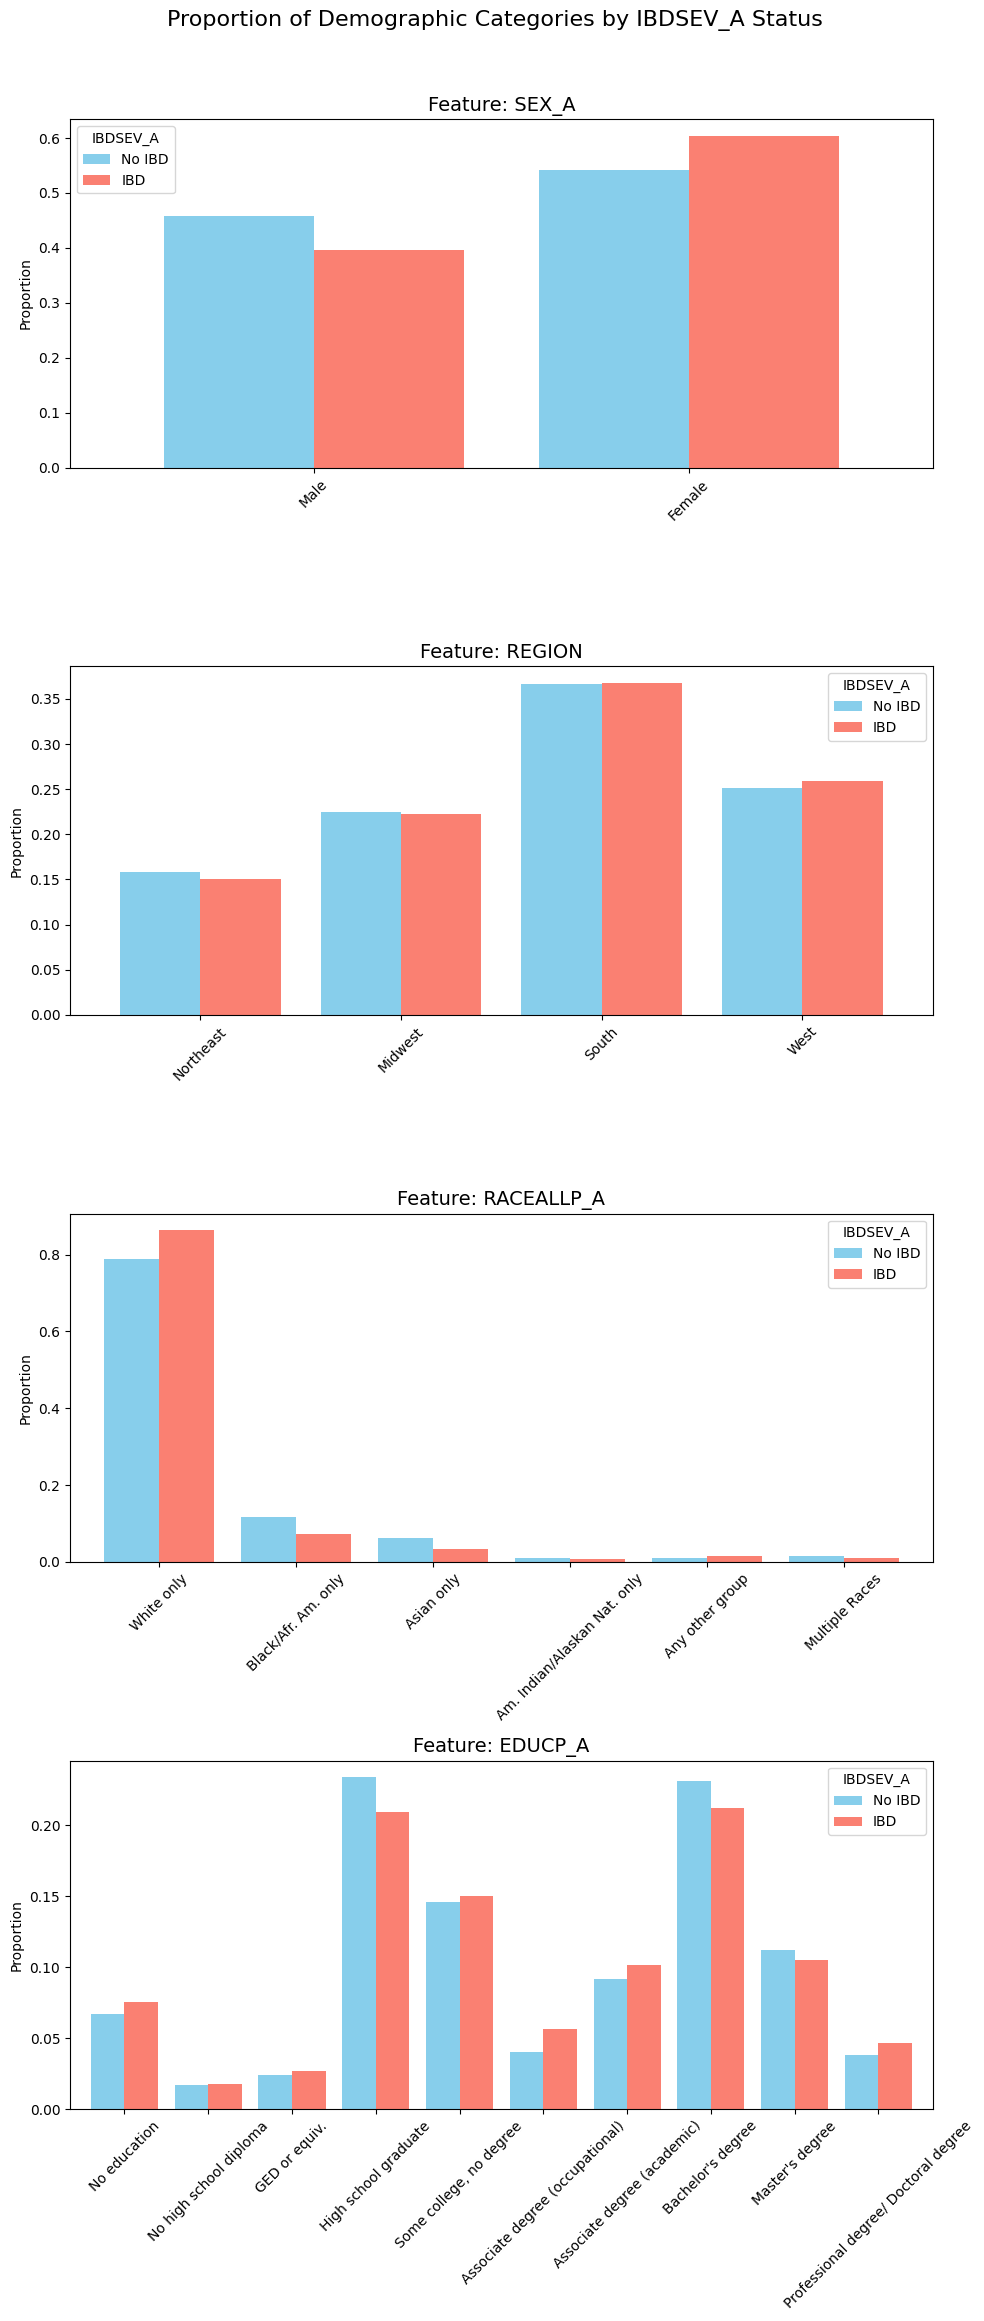

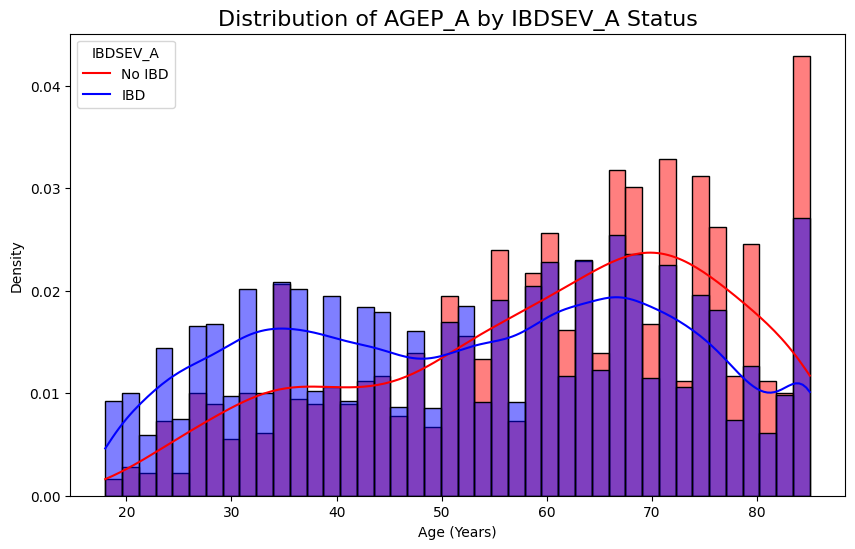

In [15]:
# Define categorical and numerical columns for plotting
categorical_cols_for_plot = ['SEX_A', 'REGION', 'RACEALLP_A', 'EDUCP_A']
numerical_col_for_plot = 'AGEP_A'
target_col = 'IBDSEV_A'

# Map numerical codes to more descriptive labels for categorical plots for better readability
sex_mapping = {1: 'Male', 2: 'Female'}
region_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
race_mapping = {
    1: 'White only',
    2: 'Black/Afr. Am. only',
    3: 'Asian only',
    4: 'Am. Indian/Alaskan Nat. only',
    5: 'Any other group',
    6: 'Multiple Races'
}
educ_mapping = {
    1: 'No education',
    2: 'No high school diploma',
    3: 'GED or equiv.',
    4: 'High school graduate',
    5: 'Some college, no degree',
    6: 'Associate degree (occupational)',
    7: 'Associate degree (academic)',
    8: 'Bachelor\'s degree',
    9: 'Master\'s degree',
    10: 'Professional degree/ Doctoral degree'
}

# Prepare figure for categorical plots
fig_cat, axes_cat = plt.subplots(len(categorical_cols_for_plot), 1, figsize=(10, 6 * len(categorical_cols_for_plot)))
fig_cat.suptitle('Proportion of Demographic Categories by IBDSEV_A Status', fontsize=16, y=0.995)

for i, col in enumerate(categorical_cols_for_plot):
    # Calculate proportions for each category within IBDSEV_A=0 and IBDSEV_A=1
    proportions = demographic_df.groupby(target_col)[col].value_counts(normalize=True).unstack(target_col)

    # Sort columns by index for consistent plotting, fill NaN with 0
    proportions = proportions.fillna(0)

    # Apply mapping for labels if available
    if col == 'SEX_A':
        proportions.rename(index=sex_mapping, inplace=True)
    elif col == 'REGION':
        proportions.rename(index=region_mapping, inplace=True)
    elif col == 'RACEALLP_A':
        proportions.rename(index=race_mapping, inplace=True)
    elif col == 'EDUCP_A':
        proportions.rename(index=educ_mapping, inplace=True)

    proportions.plot(kind='bar', ax=axes_cat[i], width=0.8, color=['skyblue', 'salmon'])
    axes_cat[i].set_title(f'Feature: {col}', fontsize=14)
    axes_cat[i].set_xlabel('') # Remove redundant x-axis label
    axes_cat[i].set_ylabel('Proportion')
    axes_cat[i].tick_params(axis='x', rotation=45)
    axes_cat[i].legend(title=target_col, labels=['No IBD', 'IBD'])

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

# Create a histogram/density plot for AGEP_A
plt.figure(figsize=(10, 6))
sns.histplot(data=demographic_df, x=numerical_col_for_plot, hue=target_col, kde=True, stat='density', common_norm=False, palette={0: 'blue', 1: 'red'})
plt.title('Distribution of AGEP_A by IBDSEV_A Status', fontsize=16)
plt.xlabel('Age (Years)')
plt.ylabel('Density')
plt.legend(title=target_col, labels=['No IBD', 'IBD'])
plt.show()

### **Converting Survey Responses to Binary Variables**

Because the meaningful responses for the non-demographic variables are essentially **Yes (1)** or **No (2)**, and the other values represent non-response categories, these variables are often treated analytically as *binary* after collapsing the non-substantive codes.

To make the dataset more usable for machine learning models, we simplify these variables as:

* **1 → “Yes”**
* **2, 7, 8, 9, NaN → “No”**



In [16]:
combined_df_processed = combined_df.copy()

print("Converting selected features to strict 0/1 binary format...")

for feature in features:
    # Ensure the feature exists in the DataFrame before attempting to convert
    if feature in combined_df_processed.columns:
        # Convert '1' to 1, and everything else (including 2, 7, 8, 9, and NaN) to 0
        combined_df_processed[feature] = (combined_df_processed[feature] == 1).astype(int)
    else:
        print(f"Warning: Feature '{feature}' not found in combined_df_processed.")

print("Conversion complete. Displaying head and value counts for a few processed features:")

display(combined_df_processed[features].head())

Converting selected features to strict 0/1 binary format...
Conversion complete. Displaying head and value counts for a few processed features:


,ARTHEV_A,SHTPNUEV_A,RX12M_A,HLTHCOND_A,SOCWRKLIM_A,MEDRXTRT_A,HIKIND02_A,COLORECTEV_A,DEPEV_A,EMPWRKLSW1_A,...,VIRAPP12M_A,INCSSRR_A,DISAB3_A,EMPSICKLV_A,HYPEV_A,HOSPONGT_A,INCWRKO_A,ANXMED_A,CHLEV_A,CTSCANEV1_A
0,1,0,1,1,1,0,1,1,1,0,...,0,1,1,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,1,1,0,0,0


### **Feature Prevalence by Target**

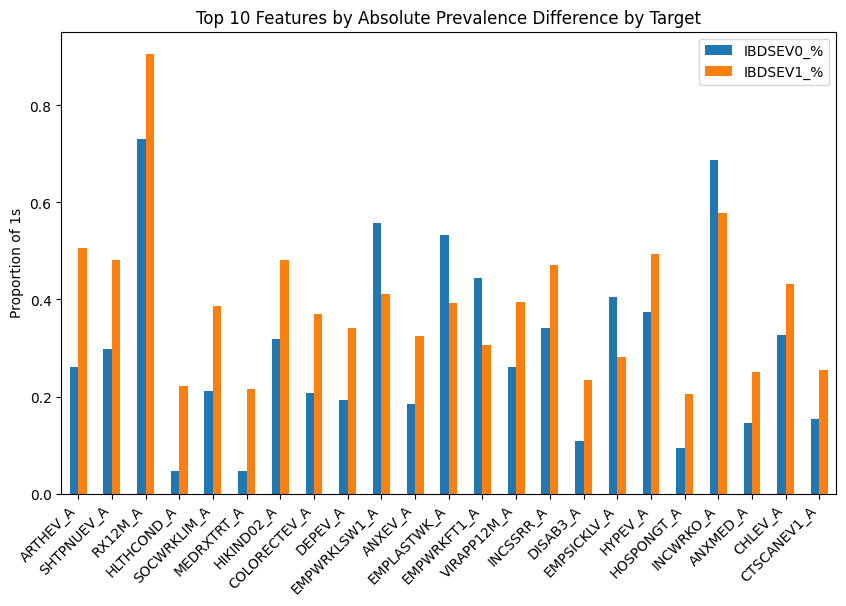

In [17]:
X_features = [col for col in combined_df_processed[features].columns if col != 'IBDSEV_A']
y_target = 'IBDSEV_A'

prevalence_by_target = pd.DataFrame()
for feature in X_features:
    ctab = pd.crosstab(combined_df_processed[feature], combined_df_processed[y_target], normalize='columns')
    prevalence_by_target.loc[feature, 'IBDSEV0_%'] = ctab.loc[1,0] if 1 in ctab.index else 0
    prevalence_by_target.loc[feature, 'IBDSEV1_%'] = ctab.loc[1,1] if 1 in ctab.index else 0

prevalence_by_target['Abs_Diff'] = (prevalence_by_target['IBDSEV1_%'] - prevalence_by_target['IBDSEV0_%']).abs()
prevalence_by_target_sorted = prevalence_by_target.sort_values('Abs_Diff', ascending=False)

# Bar plot for top 10 features
top_features = prevalence_by_target_sorted.index
prevalence_by_target_sorted.loc[top_features][['IBDSEV0_%','IBDSEV1_%']].plot.bar(figsize=(10,6))
plt.title("Top 10 Features by Absolute Prevalence Difference by Target")
plt.ylabel("Proportion of 1s")
plt.xticks(rotation=45, ha='right')
plt.show()


#### **Key Findings**

Several features show higher prevalence among individuals with IBD, and their patterns are consistent with what is known about the disease and its broader impacts.

* **Depression** (DEPEV_A) and **Anxiety** (ANXEV_A) are more common in the IBD group, which may reflect the psychological burden of living with a chronic, unpredictable gastrointestinal condition.
* Frequent prescription use (RX12M_A) and reporting multiple health conditions (**Hypertension, Arthiritis**) likely reflect the presence of comorbidities and the need for ongoing medical management.
* Similarly, a higher incidence of **social or work limitations** (SOCWRKLIM_A) and **overnight hospital stays** (HOSPONGT_A) may indicate the functional impact of severe IBD on daily life.

Conversely, employment-related features such as EMPWRKLSW1_A (Ever Worked for Employer), EMPLASTWK_A (Worked Last Week), EMPWRKFT1_A (Worked Full-time for Employer), and INCWRKO_A (Received Income from Wages/Salary) exhibit slightly higher or comparable prevalence among individuals without IBD. **This suggests that chronic illness may impact employment or income-related activities.**

### **Correlation Analysis**

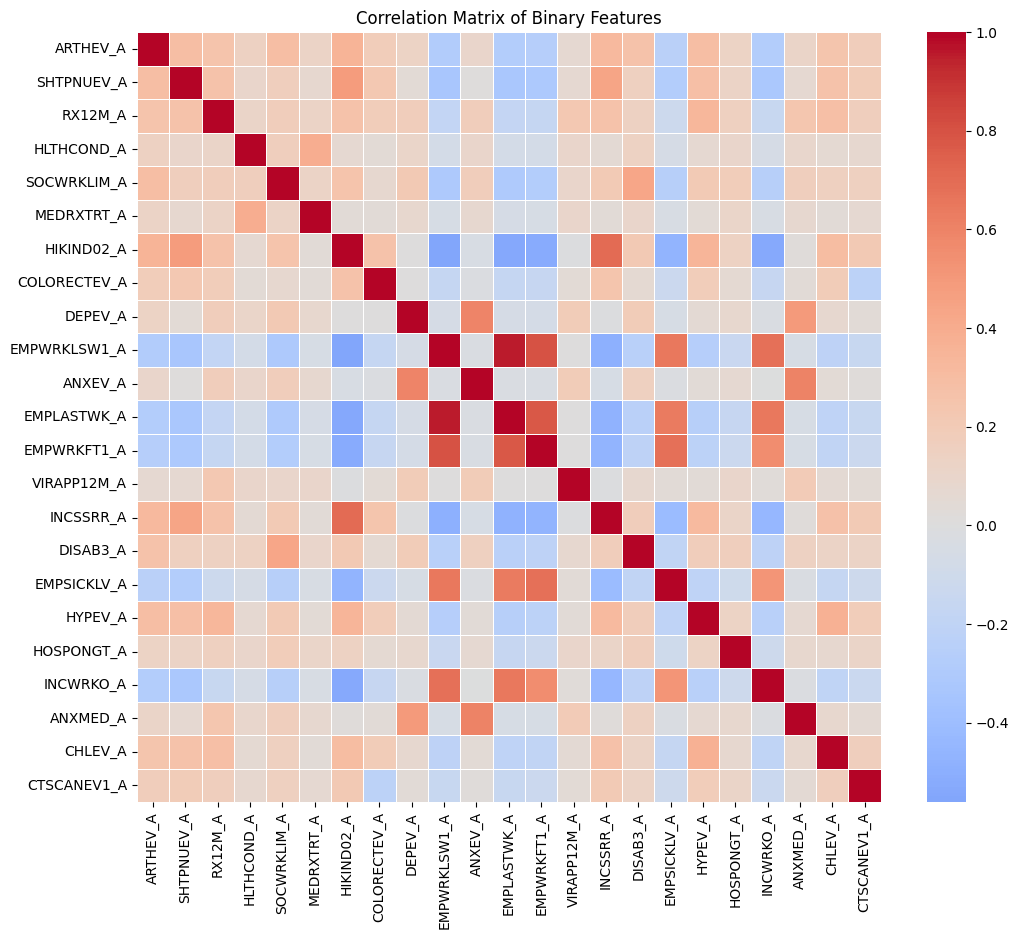

In [18]:
corr_matrix = combined_df_processed[X_features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Binary Features")
plt.show()

#### **Key Findings**

There are several noticeable clusters of dark red cells, indicating **strong positive relationships:**

* **Health-related conditions:** Features like DEPEV_A (Depression Ever) and ANXEV_A (Anxiety Ever) are strongly positively correlated, which is expected as these mental health conditions often co-occur. Similarly, HYPEV_A (Hypertension Ever) and CHLEV_A (High Cholesterol Ever) also show a strong positive correlation, reflecting common comorbidities.

* **Healthcare utilization:** HLTHCOND_A (Health Condition) and MEDRXTRT_A (Weakened immune system due to prescriptions) are highly correlated, suggesting that individuals with weakening health conditions are likely to be receiving immunosuppressive medication treatment.

* **Employment-related:** Features such as EMPWRKLSW1_A (Ever Worked for Employer), EMPLASTWK_A (Worked Last Week), and INCWRKO_A (Received Income from Wages/Salary) show strong inter-correlations, which is logical as these describe different aspects of being employed and earning income.

### **Feature Co-occurrence Heatmap**

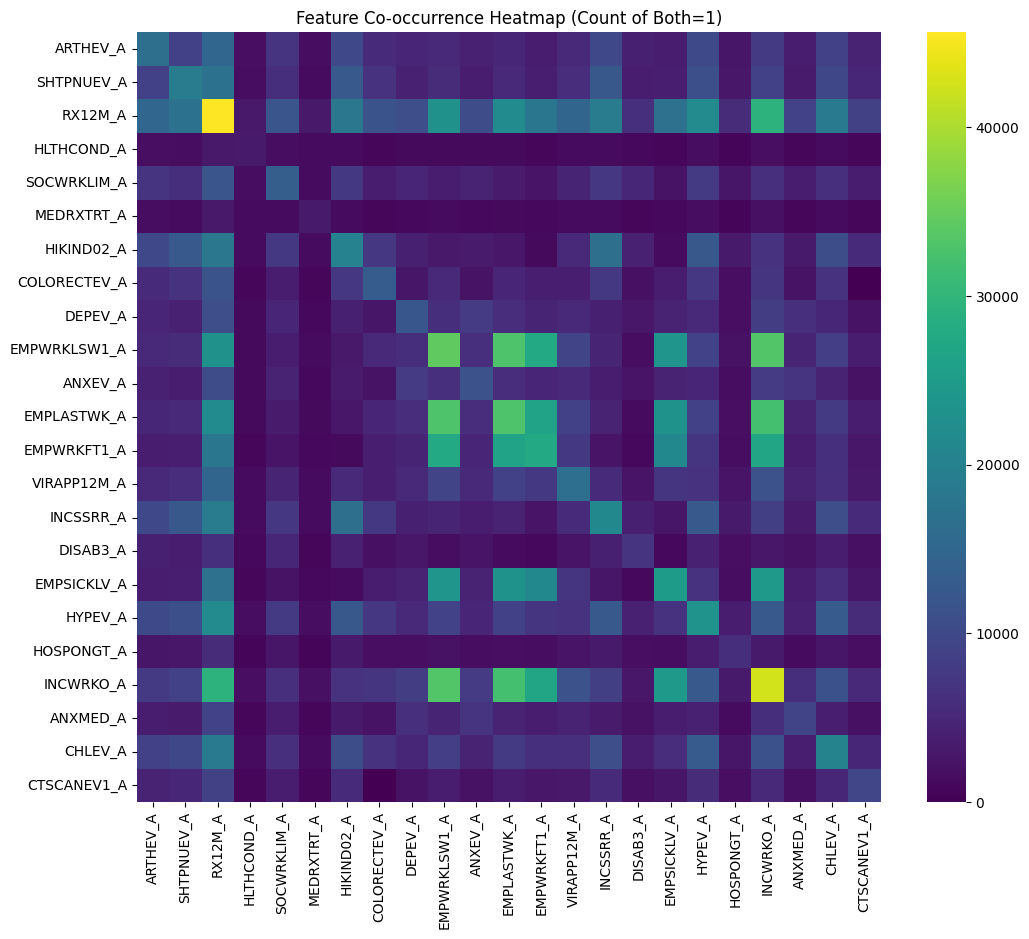

In [19]:
co_occurrence = combined_df_processed[X_features].T.dot(combined_df_processed[X_features])
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence, cmap='viridis')
plt.title("Feature Co-occurrence Heatmap (Count of Both=1)")
plt.show()


#### **Key Findings**

*  Most of the cells are dark purple, indicating that the majority of feature pairs have **low co-occurrence**. This means that it is rare for both features in such a pair to be '1' at the same time.

* This heatmap complements the correlation matrix by showing the absolute counts. It reinforces the understanding that certain groups of health-related and socio-economic factors tend to be present together in the same individuals, providing further evidence of potential clusters of related characteristics within the population.

### **PCA Visualization**

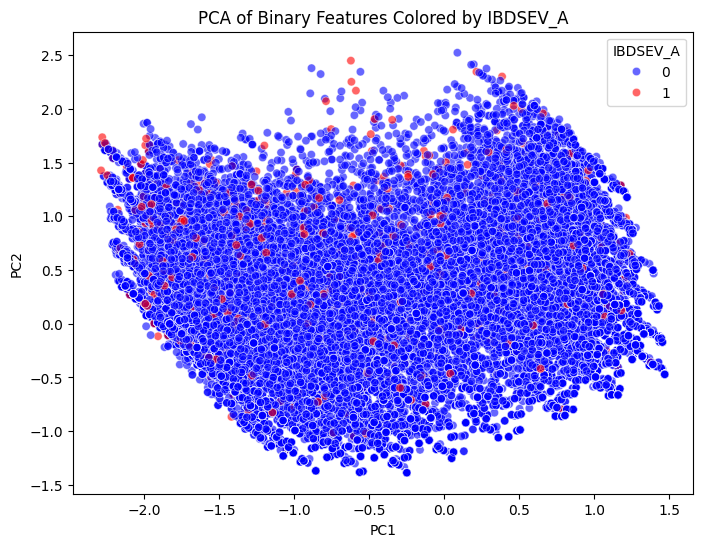

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(combined_df_processed[X_features])

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=combined_df_processed[y_target],
                palette={0:'blue', 1:'red'}, alpha=0.6)
plt.title("PCA of Binary Features Colored by IBDSEV_A")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### **Key Findings**

* **Observation of Spatial Distribution**: Upon examining the PCA plot, it is evident that the blue data points (representing `IBDSEV_A=0`) and the green data points (representing `IBDSEV_A=1`) are **heavily intermixed** throughout the 2-dimensional PCA space. There is no clear boundary or region where one class predominantly exists without significant overlap from the other.

* **Lack of Distinct Clusters**: The two classes do not form distinct, well-separated clusters. Instead, `IBDSEV_A=1` (red points) appear to be scattered widely within the larger distribution of `IBDSEV_A=0` (blue points).

* **Inference of Separability**: Based on this observation, PCA has **not effectively separated** the `IBDSEV_A` classes. The principal components, while capturing the most variance in the dataset, do not seem to project the data in a way that makes the two target classes linearly or easily non-linearly distinguishable.

*   **Challenge for Predictive Models**: The significant overlap between the two classes in the PCA-reduced space poses a considerable challenge for building effective predictive models based solely on these principal components.

Unfortunately, this means that any classifier (e.g., Logistic Regression, SVM, Decision Tree) attempting to draw a decision boundary in this space **would likely struggle to achieve high accuracy, precision, or recall for either class, especially the minority class (`IBDSEV_A=1`).**

This is not a surprise, considering the nature of using survey data to find determiners of a rare chronic condition. However, it is still worth it to explore and see what results we arrive at.



### **UMAP**

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


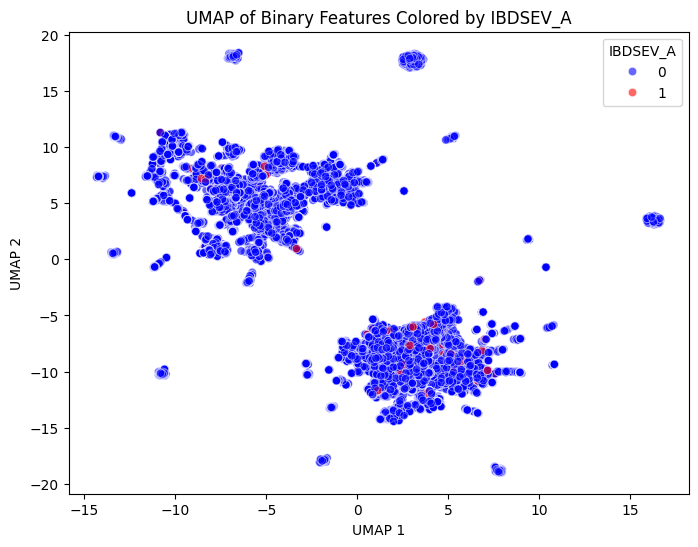

In [21]:
# Initialize UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
X_umap = reducer.fit_transform(combined_df_processed[X_features])

# Plot the 2D UMAP embedding
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_umap[:,0],
    y=X_umap[:,1],
    hue=combined_df_processed[y_target],
    palette={0:'blue', 1:'red'},
    alpha=0.6
)
plt.title("UMAP of Binary Features Colored by IBDSEV_A")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


The results are similar to PCA: **There is no clear boundary or region where one class predominantly exists without significant overlap from the other.**

## **Machine Learning Pipeline**

This is a binary classification problem with substantial class imbalance, so accuracy is not an appropriate evaluation metric. Model performance is therefore evaluated using **F1 score**, which balances precision and recall, and **ROC–AUC**, which measures ranking performance independently of any classification threshold.

To assess how different imbalance-handling strategies affect performance, we evaluate **three modeling regimes** under a unified setup:

* A **baseline approach** using built-in class weighting
* **Undersampling** of the majority class
* **Oversampling** of the minority class using SMOTE

Each regime is applied to two feature representations:

* Processed demographic features
* A reduced set of **22 selected features** (one removed due to similarity to another variable)

This allows us to examine whether resampling strategies behave differently across feature dimensionality and feature composition.

All models are evaluated using **TimeSeriesSplit with five folds** to preserve temporal ordering and avoid look-ahead bias. Within each fold, the following steps are performed:

* Missing values are imputed using **median imputation**, fit only on the training portion of the fold
* If applicable, class balancing (undersampling or SMOTE) is applied **after imputation** and only to the training data.
* Feature scaling is applied where required (e.g., logistic regression, MLP, KNN)
* The model is trained and evaluated on the validation fold

This entire sequence is implemented using `imblearn` pipelines instead of `sklearn` (compatible with undersampling and SMOTE) to prevent data leakage.

The baseline regime relies solely on algorithm-level imbalance handling, such as `class_weight="balanced"` or `scale_pos_weight` in XGBoost, without any resampling. These models serve as a reference for how much imbalance can be handled intrinsically by the learning algorithm. In the undersampling regime, the majority class is randomly downsampled to achieve a **0.5 minority-to-majority ratio** within each training fold, reducing imbalance at the cost of discarding majority-class observations. In the oversampling regime, **SMOTE** is used to synthetically generate minority-class examples up to the same ratio. Imputation is performed before SMOTE, and oversampling is strictly confined to the training folds.

We evaluate a range of models across all feature sets and imbalance strategies. Two **dummy classifiers** are included to provide baselines and to ensure that learned models outperform trivial or random predictions:

* **Dummy (Prior):** Always predicts the majority class
* **Dummy (Stratified):** Predicts according to the observed class distribution

The learned models evaluated are:

* **Logistic Regression** (class-weighted linear baseline)
* **K-Nearest Neighbors**
* **Multilayer Perceptron**
* **Random Forest**
* **Random Forest with Bagging**
* **XGBoost**

Including dummy classifiers provides a sanity check and contextualizes gains in F1 and ROC–AUC under class imbalance.

For each model and sampling strategy, hyperparameters are tuned using **GridSearchCV**, with:

* **Refit metric:** F1 score
* **Metrics recorded during CV:** F1 and ROC–AUC

The model achieving the highest mean cross-validated F1 is selected as the best configuration.

Final evaluation is performed on a held-out test set. Because classifiers output probabilities and the default threshold of 0.5 is not necessarily optimal under class imbalance, test performance is evaluated using an **optimized decision threshold**. **ROC–AUC** is computed directly from predicted probabilities and is therefore threshold-independent.

For each model, feature set, and imbalance strategy, we report:

* Cross-validated F1
* Cross-validated ROC–AUC
* Test F1 (using the optimal threshold)
* Test ROC–AUC

This setup enables controlled comparisons between built-in class weighting, undersampling, and SMOTE, while keeping the validation protocol and evaluation metrics consistent across feature sets.


### **Processing Demographic Features**

In [22]:
# Create a copy of combined_df_processed named temp_combined_df_processed
temp_combined_df_processed = combined_df_processed.copy()

# Initialize an empty list called new_features_list
new_features_list = []

# Process SEX_A
# Set its value to 1 if SEX_A is 1, to 0 if SEX_A is 2, and to np.nan for any other values
temp_combined_df_processed['SEX_A_processed'] = np.nan
temp_combined_df_processed.loc[temp_combined_df_processed['SEX_A'] == 1, 'SEX_A_processed'] = 1
temp_combined_df_processed.loc[temp_combined_df_processed['SEX_A'] == 2, 'SEX_A_processed'] = 0
new_features_list.append('SEX_A_processed')

# 4. One-hot encode the REGION column
region_dummies = pd.get_dummies(temp_combined_df_processed['REGION'], prefix='REGION', dtype=int)
temp_combined_df_processed = pd.concat([temp_combined_df_processed, region_dummies], axis=1)
new_features_list.extend(region_dummies.columns.tolist())

# One-hot encode RACEALLP_A
# Replace values 7, 8, and 9 with np.nan
temp_combined_df_processed['RACEALLP_A_cat'] = temp_combined_df_processed['RACEALLP_A'].replace({7: np.nan, 8: np.nan, 9: np.nan})
raceallp_dummies = pd.get_dummies(temp_combined_df_processed['RACEALLP_A_cat'], prefix='RACEALLP', dtype=int)
temp_combined_df_processed = pd.concat([temp_combined_df_processed, raceallp_dummies], axis=1)
new_features_list.extend(raceallp_dummies.columns.tolist())

# One-hot encode EDUCP_A
# Replace values 97, 98, and 99 with np.nan
temp_combined_df_processed['EDUCP_A_cat'] = temp_combined_df_processed['EDUCP_A'].replace({97: np.nan, 98: np.nan, 99: np.nan})
educp_dummies = pd.get_dummies(temp_combined_df_processed['EDUCP_A_cat'], prefix='EDUCP', dtype=int)
temp_combined_df_processed = pd.concat([temp_combined_df_processed, educp_dummies], axis=1)
new_features_list.extend(educp_dummies.columns.tolist())

# Process AGEP_A
# Replace values 97, 98, and 99 with np.nan
temp_combined_df_processed['AGEP_A_processed'] = temp_combined_df_processed['AGEP_A'].replace({97: np.nan, 98: np.nan, 99: np.nan})
new_features_list.append('AGEP_A_processed')

# Overwrite the original combined_df_processed with the modified temp_combined_df_processed
combined_df_processed = temp_combined_df_processed.copy()

print(f"New features added: {new_features_list}")
print("First 5 rows of combined_df_processed with new features:")
display(combined_df_processed[new_features_list].head())

New features added: ['SEX_A_processed', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'RACEALLP_1.0', 'RACEALLP_2.0', 'RACEALLP_3.0', 'RACEALLP_4.0', 'RACEALLP_5.0', 'RACEALLP_6.0', 'EDUCP_1.0', 'EDUCP_2.0', 'EDUCP_3.0', 'EDUCP_4.0', 'EDUCP_5.0', 'EDUCP_6.0', 'EDUCP_7.0', 'EDUCP_8.0', 'EDUCP_9.0', 'EDUCP_10.0', 'AGEP_A_processed']
First 5 rows of combined_df_processed with new features:


,SEX_A_processed,REGION_1,REGION_2,REGION_3,REGION_4,RACEALLP_1.0,RACEALLP_2.0,RACEALLP_3.0,RACEALLP_4.0,RACEALLP_5.0,...,EDUCP_2.0,EDUCP_3.0,EDUCP_4.0,EDUCP_5.0,EDUCP_6.0,EDUCP_7.0,EDUCP_8.0,EDUCP_9.0,EDUCP_10.0,AGEP_A_processed
0,1.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,67.0
1,1.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,73.0
2,1.0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,48.0
3,0.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,42.0
4,0.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,50.0


### **Addressing Redundant Columns**

In [23]:
# Removing feature that is too similar to another one, and extended feature list to include demographic variables

features = [f for f in features if f != "EMPWRKFT1_A"]
features.extend(new_features_list)

### **Creating Temporal Train-Test Split**


To ensure correct chronological splitting, we will create 'YEAR' and 'time_key' columns in `combined_df_processed` by deriving the year from the original dataframe lengths, handling missing values in 'INTV_QRT' and 'INTV_MON', and then combining these for the 'time_key'.



In [24]:
# Because the dataframes were concatenated as: pd.concat([adult23_df, adult24_df], ignore_index=True)
# the first len(adult23_df) rows correspond to 2023, and the remaining rows correspond to 2024.

len_adult23 = len(adult23_df)

combined_df_processed['YEAR'] = 0  # initialize column
combined_df_processed.loc[:len_adult23 - 1, 'YEAR'] = 2023
combined_df_processed.loc[len_adult23:, 'YEAR'] = 2024

# Ensure YEAR is integer
combined_df_processed['YEAR'] = combined_df_processed['YEAR'].astype(int)

# Missing interview month/quarter values imputed within each year
combined_df_processed['INTV_MON'] = (
    combined_df_processed
    .groupby('YEAR')['INTV_MON']
    .transform(lambda x: x.fillna(x.mode().iloc[0]))
)

combined_df_processed['INTV_QRT'] = (
    combined_df_processed
    .groupby('YEAR')['INTV_QRT']
    .transform(lambda x: x.fillna(x.mode().iloc[0]))
)

# Cast to integer after imputation
combined_df_processed['INTV_MON'] = combined_df_processed['INTV_MON'].astype(int)
combined_df_processed['INTV_QRT'] = combined_df_processed['INTV_QRT'].astype(int)

# time_key creates a sortable representation of time:
#   2023 Jan -> 202301
#   2024 Dec -> 202412

combined_df_processed['time_key'] = (
    combined_df_processed['YEAR'] * 100 +
    combined_df_processed['INTV_MON']
)

# TimeSeriesSplit
combined_df_processed = (
    combined_df_processed
    .sort_values(by='time_key')
    .reset_index(drop=True)
)

display(
    combined_df_processed[['YEAR', 'INTV_QRT', 'INTV_MON', 'time_key']].head()
)



,YEAR,INTV_QRT,INTV_MON,time_key
0,2023,1,1,202301
1,2023,1,1,202301
2,2023,1,1,202301
3,2023,1,1,202301
4,2023,1,1,202301


In [25]:
# Sort the combined_df_processed DataFrame by the time_key column in ascending order
combined_df_processed_sorted = combined_df_processed.sort_values(by='time_key').reset_index(drop=True)

# Define the training, validation, and test set sizes (80/20 split)
total_rows = len(combined_df_processed_sorted)
train_size = int(0.8 * total_rows)
test_size = total_rows - train_size # Ensure all rows are covered

# Calculate the indices for these splits
train_end_idx = train_size

# Create the training set
X_train = combined_df_processed_sorted.loc[:train_end_idx-1, features]
y_train = combined_df_processed_sorted.loc[:train_end_idx-1, target]

# Create the test set
X_test = combined_df_processed_sorted.loc[train_end_idx:, features]
y_test = combined_df_processed_sorted.loc[train_end_idx:, target]

# Print the shapes to verify the split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (49720, 44)
Shape of y_train: (49720,)
Shape of X_test: (12431, 44)
Shape of y_test: (12431,)


### **Setting up Pipeline - The Backbone**

In [26]:
imputer = SimpleImputer(strategy="median")

tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    "f1": make_scorer(f1_score),
    "roc_auc": "roc_auc"
}

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos


In [27]:
def get_sampler(strategy):
    if strategy == "none":
        return None
    if strategy == "undersample":
        return RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    if strategy == "smote":
        return SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
    raise ValueError(f"Unknown sampling strategy: {strategy}")

In [28]:
def build_pipeline(estimator, sampler, imputer, scaler):
    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("imputer", imputer))
    if scaler:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", estimator))
    return Pipeline(steps)

In [29]:
def get_models(sampling_strategy):
    sampler = get_sampler(sampling_strategy)

    models = {
        "Dummy (Majority)": (
            build_pipeline(
                DummyClassifier(strategy="prior", random_state=42),
                imputer, sampler, False
            ),
            {}
        ),
        "Dummy (Stratified)": (
            build_pipeline(
                DummyClassifier(strategy="stratified", random_state=42),
                imputer, sampler, False
            ),
            {}
        ),
        "Logistic Regression": (
            build_pipeline(
                LogisticRegression(
                    class_weight="balanced",
                    max_iter=1000
                ),
                imputer, sampler, True
            ),
            {"clf__C": [0.01, 0.1, 1, 10],
             "clf__solver" : ['liblinear', 'saga']}
        ),
        "XGBoost": (
            build_pipeline(
                XGBClassifier(
                    objective="binary:logistic",
                    eval_metric="logloss",
                    scale_pos_weight=scale_pos_weight,
                    random_state=42,
                    use_label_encoder=False
                ),
                imputer, sampler, True
            ),
            {
                "clf__n_estimators": [100, 200, 300],
                "clf__max_depth": [3, 5, 7],
                "clf__learning_rate": [0.01, 0.05, 0.1],
                "clf__subsample": [0.8, 1.0],
                "clf__colsample_bytree": [0.7, 0.8, 0.9],
                "clf__gamma": [0, 0.1, 0.2]
            }
        ),
        "MLP": (
            build_pipeline(
                MLPClassifier(max_iter=500, random_state=42),
                imputer, sampler, True
            ),
            {
                "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
                "clf__alpha": [0.0001, 0.001],
                'clf__activation': ['relu', 'tanh'],
                'clf__solver': ['adam', 'sgd']
            }
        ),
        "KNN": (
            build_pipeline(
                KNeighborsClassifier(),
                imputer, sampler, True
            ),
            {
                "clf__n_neighbors": [5, 15, 25],
                "clf__weights": ["uniform", "distance"]
            }
        ),
        "Random Forest": (
            build_pipeline(
                RandomForestClassifier(
                    class_weight="balanced",
                    random_state=42
                ),
                imputer, sampler, True
            ),
            {
                "clf__n_estimators": [200, 500],
                "clf__max_depth": [None, 10, 20],
                "clf__min_samples_split": [2, 5]
            }
        ),
        "Random Forest + Bagging": (
            build_pipeline(
                BaggingClassifier(
                    estimator=RandomForestClassifier(
                        class_weight="balanced",
                        random_state=42
                    ),
                    random_state=42
                ),
                imputer, sampler, True
            ),
            {
                "clf__n_estimators": [10, 30],
                "clf__estimator__n_estimators": [100, 300],
                "clf__estimator__max_depth": [None, 10]
            }
        )
    }

    return models

In [30]:
def run_gridsearch(models, X_train, y_train):
    results = []
    fitted_models = {}

    for name, (pipe, grid) in models.items():
        print(f"\nRunning GridSearchCV for {name}...")

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring=scoring,
            refit="f1",
            cv=tscv,
            n_jobs=-1,
            verbose=1
        )

        gs.fit(X_train, y_train)

        best_model = gs.best_estimator_
        fitted_models[name] = best_model

        # ---- Probabilities
        if hasattr(best_model, "predict_proba"):
            y_test_proba = best_model.predict_proba(X_test)[:, 1]
        else:
            y_test_proba = best_model.decision_function(X_test)

        # ---- Optimal threshold (max F1)
        thresholds = np.linspace(0.01, 0.99, 99)
        f1_scores = []
        recall_scores = []
        for t in thresholds:
            y_pred_t = (y_test_proba >= t).astype(int)
            f1_scores.append(f1_score(y_test, y_pred_t, pos_label=1))
            recall_scores.append(recall_score(y_test, y_pred_t, pos_label=1))

        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_test_f1 = f1_scores[best_idx]

        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        test_roc_auc = roc_auc_score(y_test, y_test_proba)

        results.append({
            "Model": name,
            "Test F1 (Optimal Threshold)": best_test_f1,
            "Test ROC-AUC": test_roc_auc,
            "Test Recall (Optimal Threshold)": recall_scores[best_idx],
            "Best F1 (CV)": gs.cv_results_["mean_test_f1"][gs.best_index_],
            "Best ROC-AUC (CV)": gs.cv_results_["mean_test_roc_auc"][gs.best_index_],
            "Optimal Threshold": best_threshold,
            "Best Params": gs.best_params_
        })

    results_df = pd.DataFrame(results).sort_values(
    by="Test F1 (Optimal Threshold)", ascending=False)

    return results_df, fitted_models


In [31]:
def extract_feature_importances(fitted_models, feature_names):
    importances = {}

    for name, pipe in fitted_models.items():
        clf = pipe.named_steps["clf"]

        if isinstance(clf, RandomForestClassifier):
            imp = pd.Series(clf.feature_importances_, index=feature_names)
            importances[name] = imp.sort_values(ascending=False)

        elif isinstance(clf, BaggingClassifier):
            avg_imp = np.mean(
                [est.feature_importances_ for est in clf.estimators_],
                axis=0
            )
            imp = pd.Series(avg_imp, index=feature_names)
            importances[name] = imp.sort_values(ascending=False)

        elif isinstance(clf, LogisticRegression):
            coef = pd.Series(clf.coef_[0], index=feature_names)
            importances[name] = coef.reindex(coef.abs().sort_values(ascending=False).index)

        elif isinstance(clf, XGBClassifier):
            imp = pd.Series(clf.feature_importances_, index=feature_names)
            importances[name] = imp.sort_values(ascending=False)

    return importances

In [32]:
def plot_feature_importances(importances, top_n=20):
    n = len(importances)
    rows = int(np.ceil(n / 2))

    fig, axes = plt.subplots(rows, 2, figsize=(16, 6 * rows))
    axes = axes.flatten()

    for ax, (name, imp) in zip(axes, importances.items()):
        imp.head(top_n).sort_values().plot(kind="barh", ax=ax)
        ax.set_title(name)
        ax.set_xlabel("Importance / Coefficient")

    for ax in axes[len(importances):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## **Model Training, Evaluation, and Feature Importances**

### **Baseline Sampling**

In [33]:
models_none = get_models("none")
results_none, fitted_models = run_gridsearch(models_none, X_train, y_train)



Running GridSearchCV for Dummy (Majority)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Dummy (Stratified)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:36:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Running GridSearchCV for MLP...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for Random Forest + Bagging...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [34]:
display(results_none)

,Model,Test F1 (Optimal Threshold),Test ROC-AUC,Test Recall (Optimal Threshold),Best F1 (CV),Best ROC-AUC (CV),Optimal Threshold,Best Params
2,Logistic Regression,0.121212,0.745417,0.223301,0.080868,0.745163,0.77,"{'clf__C': 0.01, 'clf__solver': 'liblinear'}"
3,XGBoost,0.107563,0.711577,0.155340,0.092561,0.697880,0.66,"{'clf__colsample_bytree': 0.7, 'clf__gamma': 0..."
6,Random Forest,0.094994,0.710903,0.179612,0.071577,0.699440,0.51,"{'clf__max_depth': 10, 'clf__min_samples_split..."
7,Random Forest + Bagging,0.079121,0.695297,0.174757,0.049072,0.691317,0.44,"{'clf__estimator__max_depth': 10, 'clf__estima..."
5,KNN,0.069457,0.559233,0.189320,0.017746,0.553786,0.01,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."
4,MLP,0.059497,0.604076,0.063107,0.066326,0.586314,0.23,"{'clf__activation': 'relu', 'clf__alpha': 0.00..."
1,Dummy (Stratified),0.048544,0.516255,0.048544,0.018730,0.500518,0.01,{}
0,Dummy (Majority),0.032603,0.500000,1.000000,0.000000,0.500000,0.01,{}


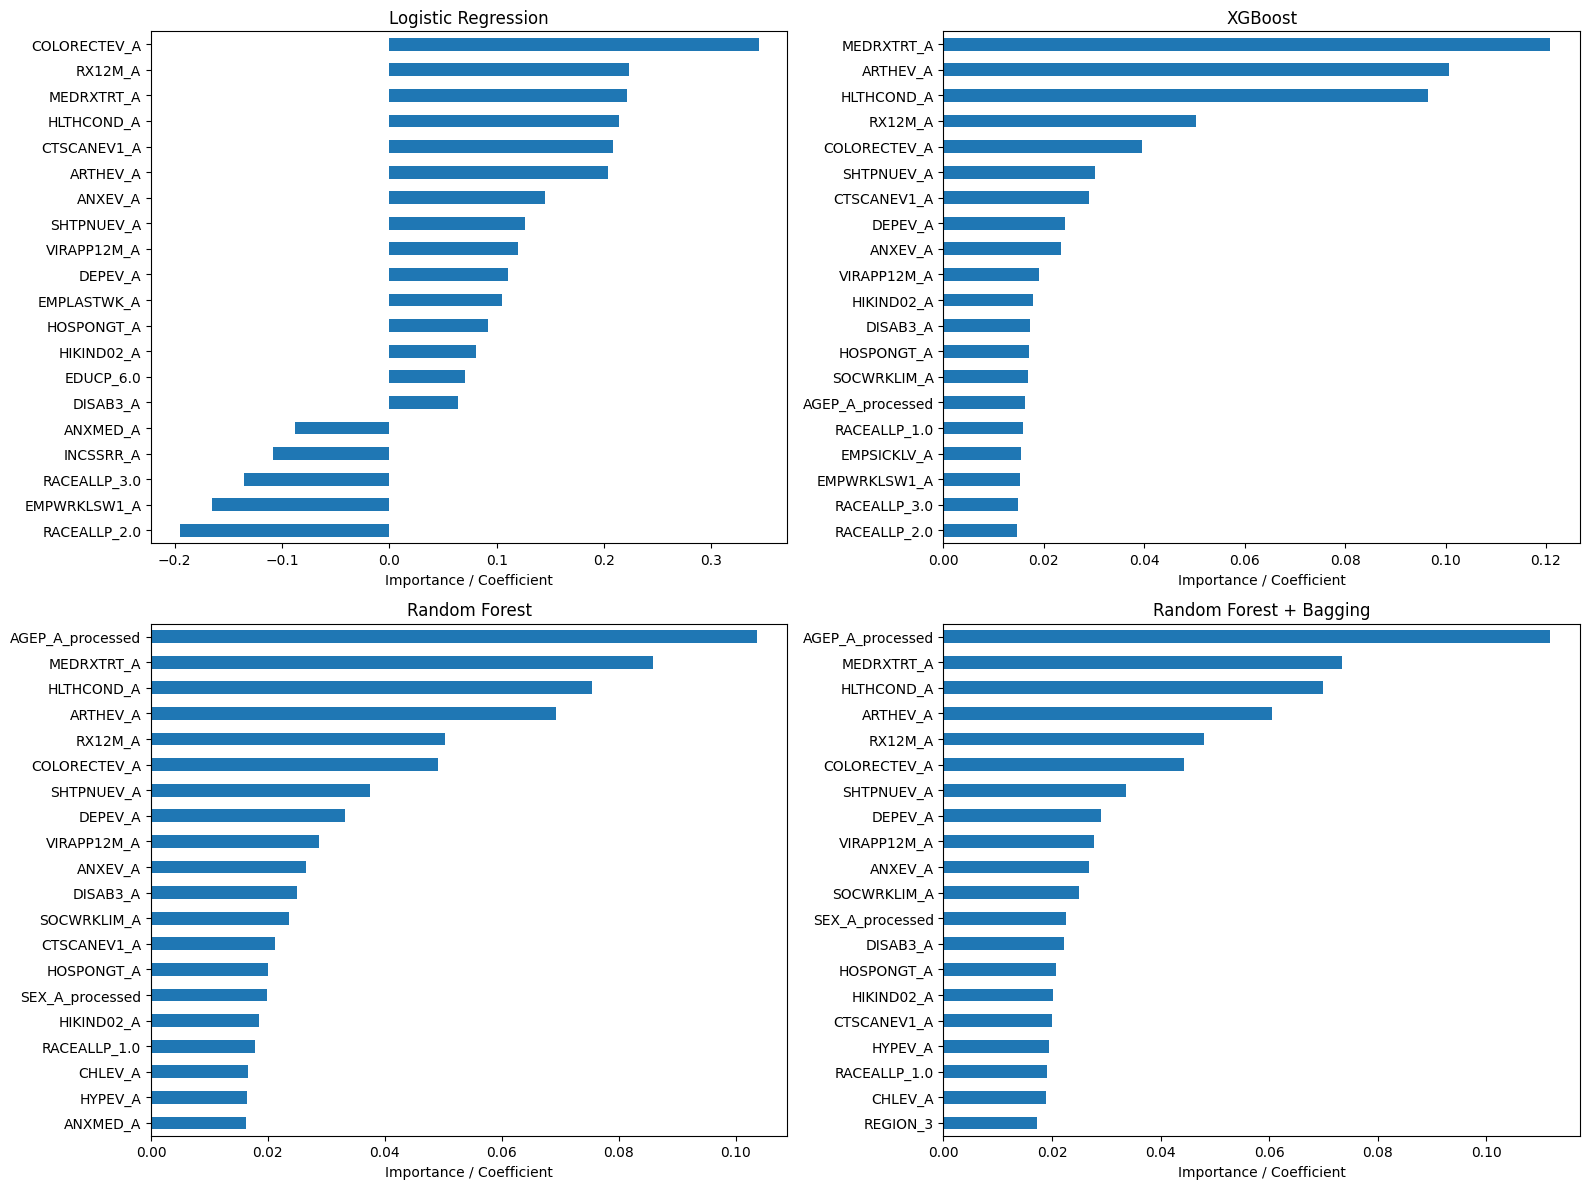

In [35]:
feature_names = X_train.columns

importances = extract_feature_importances(
    fitted_models,
    feature_names
)

plot_feature_importances(importances, top_n=20)

### **Under-Sampling with Random Undersampler**

In [36]:
models_under = get_models("undersample")
results_under, fitted_models = run_gridsearch(models_under, X_train, y_train)


Running GridSearchCV for Dummy (Majority)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Dummy (Stratified)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:44:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Running GridSearchCV for MLP...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for Random Forest + Bagging...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [37]:
display(results_under)

,Model,Test F1 (Optimal Threshold),Test ROC-AUC,Test Recall (Optimal Threshold),Best F1 (CV),Best ROC-AUC (CV),Optimal Threshold,Best Params
7,Random Forest + Bagging,0.125000,0.733712,0.199029,0.112138,0.743084,0.58,"{'clf__estimator__max_depth': None, 'clf__esti..."
2,Logistic Regression,0.122340,0.737649,0.223301,0.078656,0.741743,0.77,"{'clf__C': 1, 'clf__solver': 'saga'}"
4,MLP,0.119454,0.738426,0.169903,0.098180,0.744589,0.68,"{'clf__activation': 'tanh', 'clf__alpha': 0.00..."
6,Random Forest,0.113924,0.725157,0.174757,0.101888,0.736240,0.61,"{'clf__max_depth': 20, 'clf__min_samples_split..."
5,KNN,0.097561,0.705441,0.077670,0.102086,0.711048,0.65,"{'clf__n_neighbors': 25, 'clf__weights': 'unif..."
3,XGBoost,0.078125,0.676337,0.218447,0.063631,0.700917,0.97,"{'clf__colsample_bytree': 0.8, 'clf__gamma': 0..."
0,Dummy (Majority),0.032603,0.500000,1.000000,0.000000,0.500000,0.01,{}
1,Dummy (Stratified),0.026217,0.471914,0.271845,0.035370,0.505574,0.01,{}


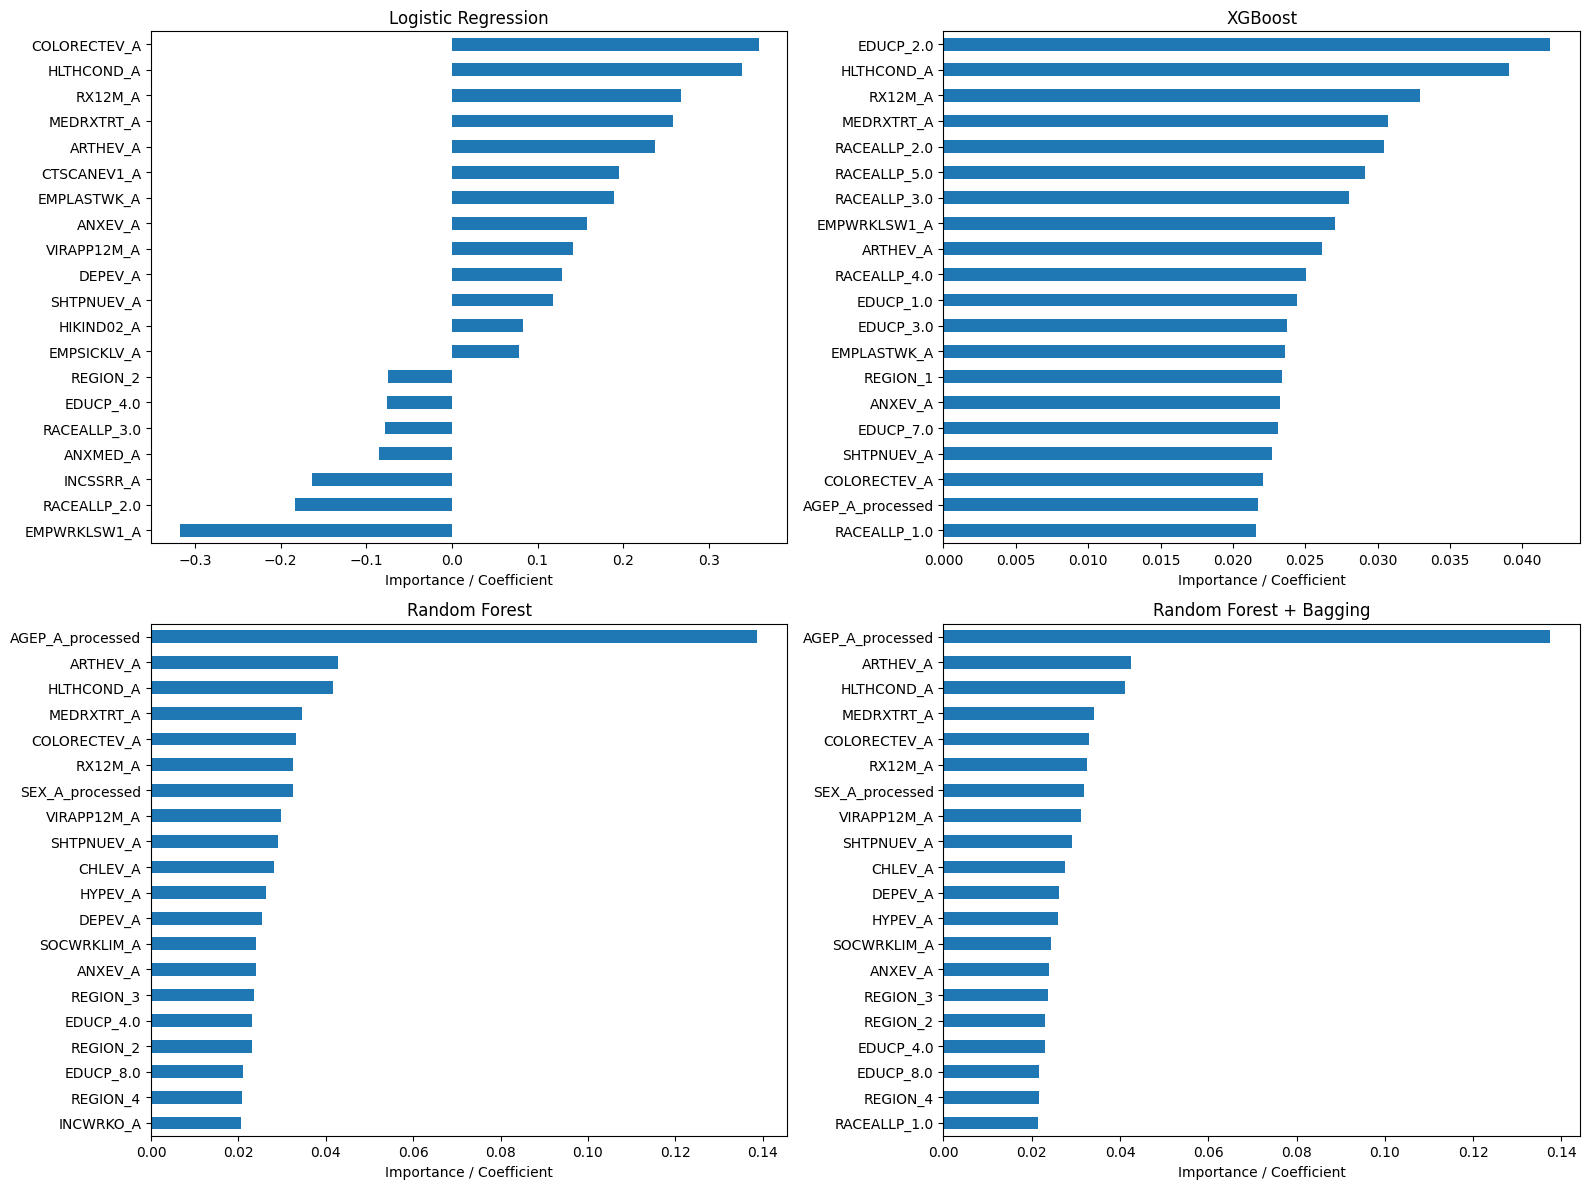

In [38]:
feature_names = X_train.columns

importances = extract_feature_importances(
    fitted_models,
    feature_names
)

plot_feature_importances(importances, top_n=20)

### **Over-Sampling with SMOTE**

In [39]:
models_smote = get_models("smote")
results_smote, fitted_models = run_gridsearch(models_smote, X_train, y_train)


Running GridSearchCV for Dummy (Majority)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Dummy (Stratified)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Running GridSearchCV for MLP...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Running GridSearchCV for KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for Random Forest + Bagging...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [40]:
display(results_smote)

,Model,Test F1 (Optimal Threshold),Test ROC-AUC,Test Recall (Optimal Threshold),Best F1 (CV),Best ROC-AUC (CV),Optimal Threshold,Best Params
2,Logistic Regression,0.123867,0.727041,0.199029,0.081966,0.732930,0.78,"{'clf__C': 0.01, 'clf__solver': 'saga'}"
7,Random Forest + Bagging,0.091770,0.721773,0.305825,0.045478,0.730157,0.29,"{'clf__estimator__max_depth': 10, 'clf__estima..."
6,Random Forest,0.088925,0.717504,0.266990,0.051976,0.727390,0.30,"{'clf__max_depth': 10, 'clf__min_samples_split..."
3,XGBoost,0.088757,0.643946,0.072816,0.091030,0.641758,0.81,"{'clf__colsample_bytree': 0.7, 'clf__gamma': 0..."
5,KNN,0.078136,0.611714,0.276699,0.077160,0.598526,0.36,"{'clf__n_neighbors': 5, 'clf__weights': 'dista..."
4,MLP,0.051392,0.574589,0.116505,0.076151,0.606574,0.22,"{'clf__activation': 'tanh', 'clf__alpha': 0.00..."
0,Dummy (Majority),0.032603,0.500000,1.000000,0.000000,0.500000,0.01,{}
1,Dummy (Stratified),0.026217,0.471914,0.271845,0.035373,0.505587,0.01,{}


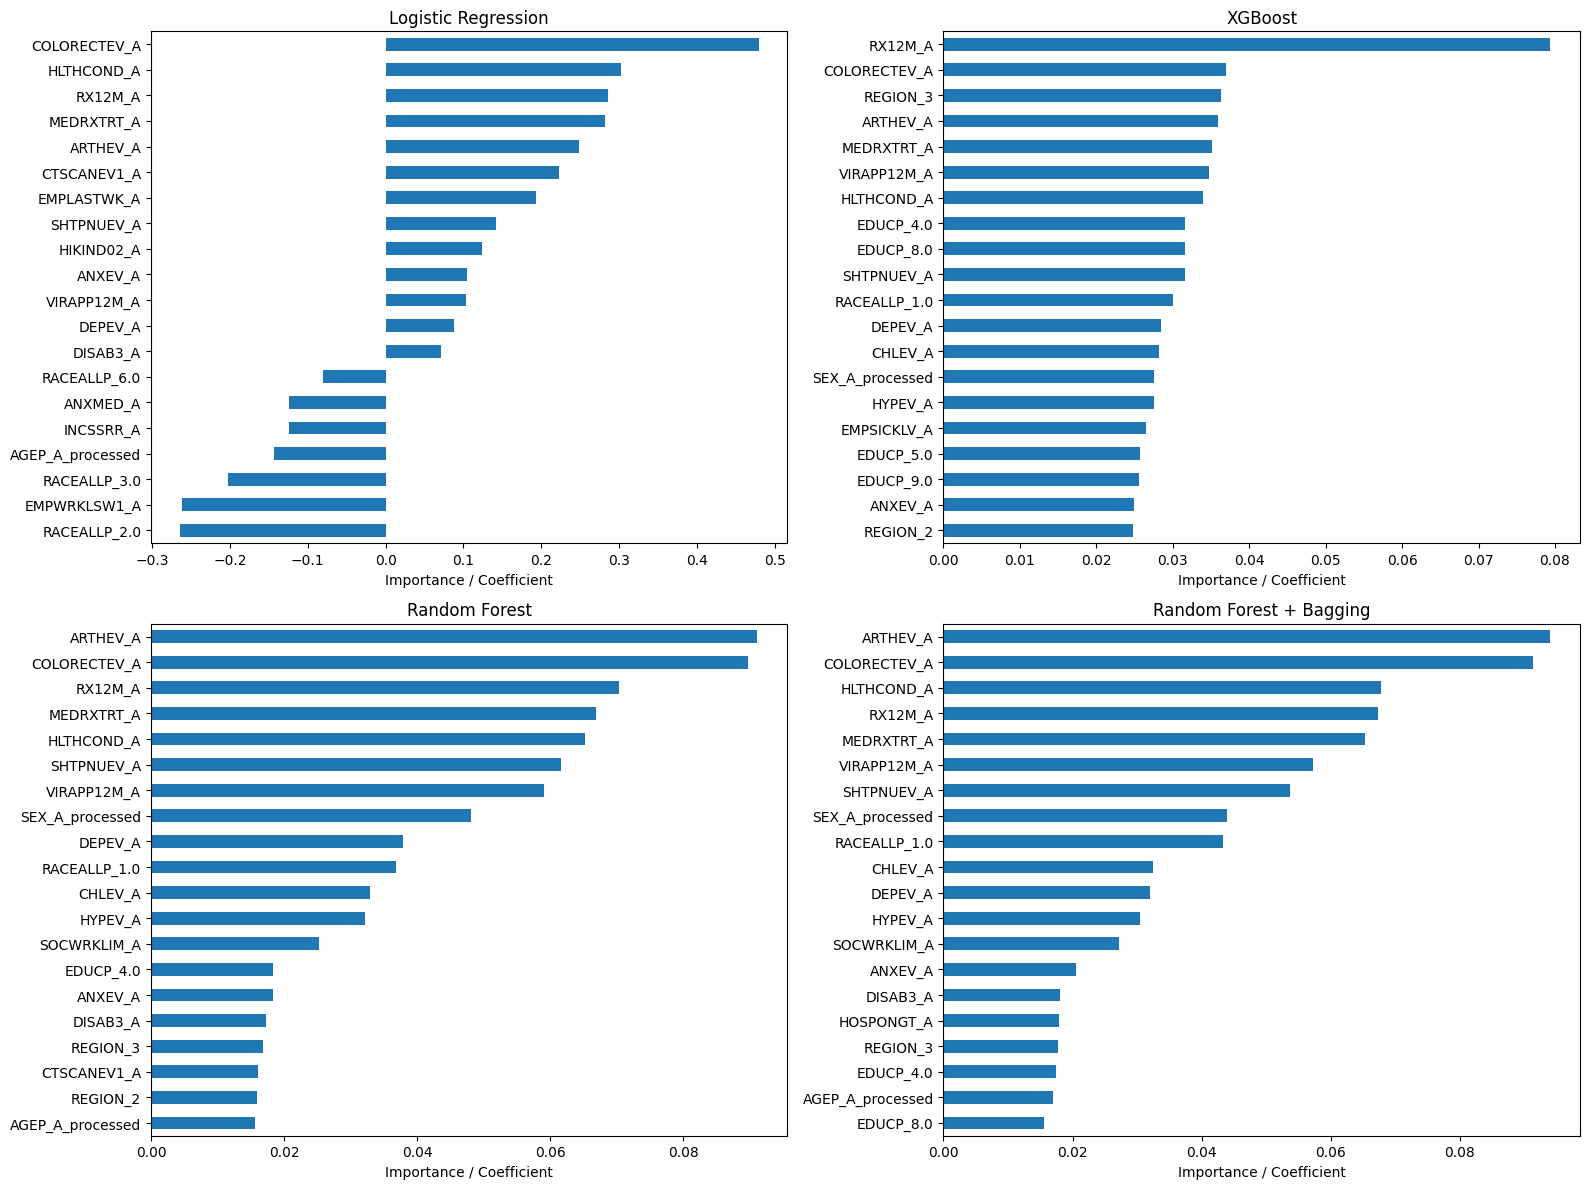

In [41]:
feature_names = X_train.columns

importances = extract_feature_importances(
    fitted_models,
    feature_names
)

plot_feature_importances(importances, top_n=20)

### **Ensemble Models - Stacking Classifier**

In [42]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Extract best parameters from results_under for each base estimator
rf_bag_params = results_under[results_under['Model'] == 'Random Forest + Bagging']['Best Params'].iloc[0]
knn_params = results_under[results_under['Model'] == 'KNN']['Best Params'].iloc[0]
lr_params = results_under[results_under['Model'] == 'Logistic Regression']['Best Params'].iloc[0]

# Instantiate the base estimators
# RandomForestClassifier for the BaggingClassifier's estimator
rf_base_estimator = RandomForestClassifier(
    n_estimators=rf_bag_params['clf__estimator__n_estimators'],
    max_depth=rf_bag_params['clf__estimator__max_depth'],
    class_weight='balanced',
    random_state=42
)

# BaggingClassifier as one of the base estimators
bagging_clf_base = BaggingClassifier(
    estimator=rf_base_estimator,
    n_estimators=rf_bag_params['clf__n_estimators'],
    random_state=42
)

# KNeighborsClassifier as one of the base estimators
knn_clf_base = KNeighborsClassifier(
    n_neighbors=knn_params['clf__n_neighbors'],
    weights=knn_params['clf__weights']
)

# LogisticRegression as one of the base estimators
lr_clf_base = LogisticRegression(
    C=lr_params['clf__C'],
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear'
)

# Create a list of tuples for the base estimators
base_estimators = [
    ('rf_bag', bagging_clf_base),
    ('knn', knn_clf_base),
    ('lr', lr_clf_base)
]

# Instantiate the final meta-classifier
meta_classifier = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

# Define the parameter grid for the StackingClassifier
param_grid_stacking = {
    'clf__final_estimator__C': [0.1, 1, 10],
    'clf__final_estimator__penalty': ['l1', 'l2']
}

print("Stacking Classifier setup complete.")
print(f"Stacking Classifier pipeline defined with base estimators: {', '.join([name for name, _ in base_estimators])} and Logistic Regression meta-classifier.")
print("Parameter grid for stacking classifier:")
print(param_grid_stacking)

Stacking Classifier setup complete.
Stacking Classifier pipeline defined with base estimators: rf_bag, knn, lr and Logistic Regression meta-classifier.
Parameter grid for stacking classifier:
{'clf__final_estimator__C': [0.1, 1, 10], 'clf__final_estimator__penalty': ['l1', 'l2']}


In [43]:
# Run GridSearchCV for the StackingClassifier
print("\nRunning GridSearchCV for StackingClassifier...")

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5,
    n_jobs=-1
)

# Update the stacking_model_pipeline with the corrected stacking_clf
stacking_model_pipeline = Pipeline(steps=[
    ('sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', stacking_clf)
])

gs_stacking = GridSearchCV(
    estimator=stacking_model_pipeline,
    param_grid=param_grid_stacking,
    scoring=scoring,
    refit="f1",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

gs_stacking.fit(X_train, y_train)

# Get the best StackingClassifier model
best_stacking_model = gs_stacking.best_estimator_

# Make predictions and calculate performance on the test set
y_test_pred_stacking = best_stacking_model.predict(X_test)

if hasattr(best_stacking_model, "predict_proba"):
    y_test_proba_stacking = best_stacking_model.predict_proba(X_test)[:, 1]
else:
    y_test_proba_stacking = best_stacking_model.decision_function(X_test)

thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []
recall_scores = []

for t in thresholds:
    y_pred_t = (y_test_proba_stacking >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))
    recall_scores.append(recall_score(y_test, y_pred_t))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_recall = recall_scores[best_idx]

# Final predictions using optimal threshold
y_test_pred_stacking = (y_test_proba_stacking >= best_threshold).astype(int)

test_roc_auc_stacking = roc_auc_score(y_test, y_test_proba_stacking)

print("\n--- Stacking Test Set Evaluation ---")
print("Test F1 for StackingClassifier:", best_f1)
print("Test Recall for StackingClassifier:", best_recall)
print("Test ROC-AUC for StackingClassifier:", test_roc_auc_stacking)
print("Best F1 (CV)", gs_stacking.cv_results_["mean_test_f1"][gs_stacking.best_index_])
print("Best ROC-AUC (CV)", gs_stacking.cv_results_["mean_test_roc_auc"][gs_stacking.best_index_])
print("Best Params", gs_stacking.best_params_)


Running GridSearchCV for StackingClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Stacking Test Set Evaluation ---
Test F1 for StackingClassifier: 0.12692307692307692
Test Recall for StackingClassifier: 0.16019417475728157
Test ROC-AUC for StackingClassifier: 0.7421565707705442
Best F1 (CV) 0.07658702466356784
Best ROC-AUC (CV) 0.7447574210089588
Best Params {'clf__final_estimator__C': 1, 'clf__final_estimator__penalty': 'l1'}


## **Visual Comparison of Model Performance Across Sampling Methods**

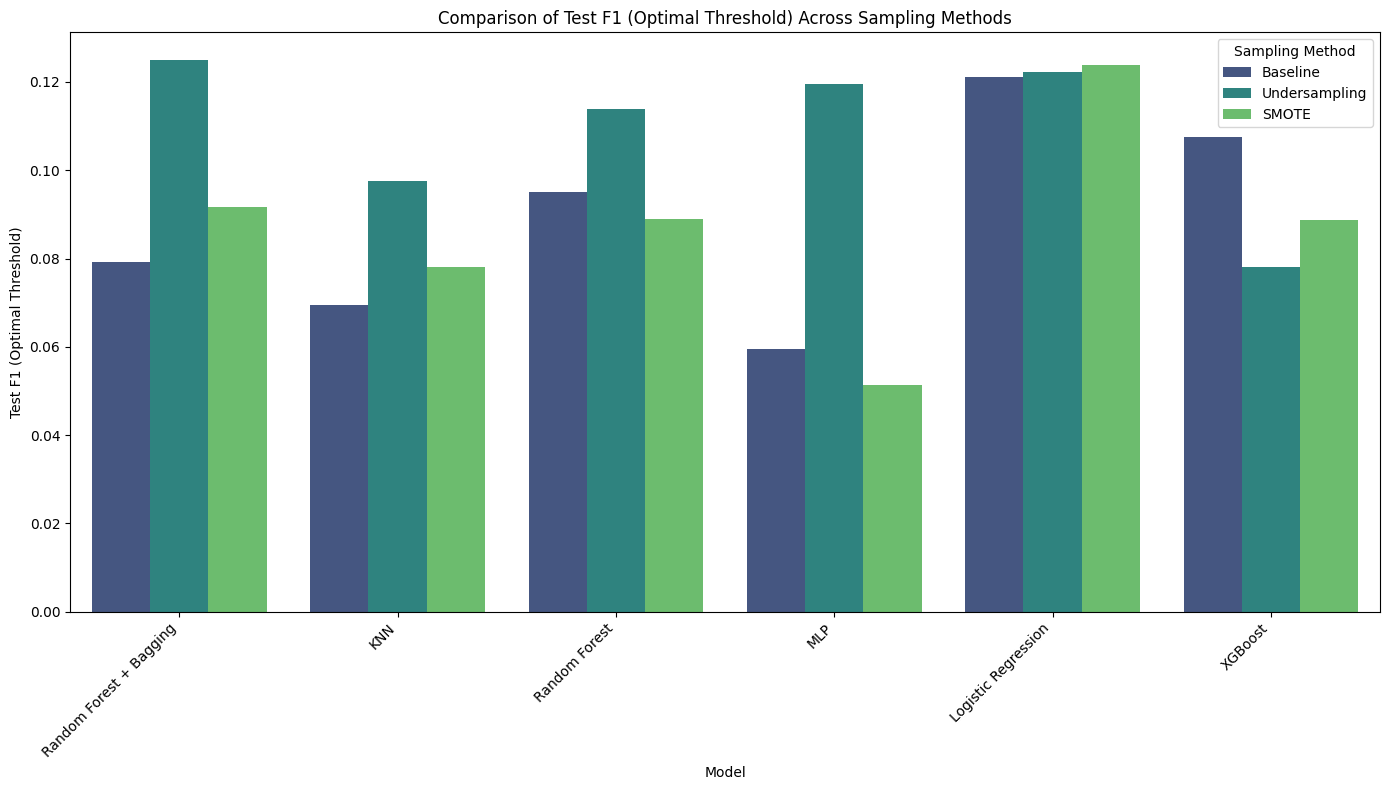

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all results dataframes are available. If not, re-run relevant cells.
# Assuming results_none, results_under, and results_smote are already in memory.

# Add 'Sampling Method' column to each results DataFrame
results_none['Sampling Method'] = 'Baseline'
results_under['Sampling Method'] = 'Undersampling'
results_smote['Sampling Method'] = 'SMOTE'

# Concatenate all results into a single DataFrame for plotting
all_results = pd.concat([results_none, results_under, results_smote], ignore_index=True)

# Filter out Dummy Classifiers for cleaner comparison of learned models
learned_models_results = all_results[~all_results['Model'].str.contains('Dummy')].copy()

# Sort models by their best F1 score in the Undersampling regime for consistent ordering
# Use the Undersampling results as it generally showed better performance for most models
order_f1 = learned_models_results[learned_models_results['Sampling Method'] == 'Undersampling'].sort_values('Best F1 (CV)', ascending=False)['Model'].tolist()

# Plotting F1 Score
plt.figure(figsize=(14, 8))
sns.barplot(data=learned_models_results, x='Model', y='Test F1 (Optimal Threshold)', hue='Sampling Method', palette='viridis', order=order_f1)
plt.title('Comparison of Test F1 (Optimal Threshold) Across Sampling Methods')
plt.ylabel('Test F1 (Optimal Threshold)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling Method')
plt.tight_layout()
plt.show()
plt.savefig('f1_comparison.png')


## **Test F1 Comparison Across Sampling Methods**

In [47]:
import pandas as pd

# Ensure learned_models_results DataFrame is available from previous steps
# (It should contain results from baseline, undersampling, and SMOTE for learned models)

# Create a pivot table for Test F1 scores
f1_comparison_df = learned_models_results.pivot_table(
    index='Model',
    columns='Sampling Method',
    values='Test F1 (Optimal Threshold)',
    aggfunc='first' # 'first' is safe here because each model/sampling method pair has one Test F1
)

# Sort the DataFrame by Test F1 under Undersampling (or any other preferred method) for better readability
f1_comparison_df_sorted = f1_comparison_df.sort_values(by='Undersampling', ascending=False)

print("DataFrame of Test F1 Scores Across Sampling Methods:")
display(f1_comparison_df_sorted)

DataFrame of Test F1 Scores Across Sampling Methods:


Sampling Method,Baseline,SMOTE,Undersampling
Model,,,
Random Forest + Bagging,0.079121,0.091770,0.125000
Logistic Regression,0.121212,0.123867,0.122340
MLP,0.059497,0.051392,0.119454
Random Forest,0.094994,0.088925,0.113924
KNN,0.069457,0.078136,0.097561
XGBoost,0.107563,0.088757,0.078125


In [48]:
import pandas as pd

# Ensure all_results DataFrame is available from previous steps
# (It contains results from baseline, undersampling, and SMOTE for ALL models, including dummies)

# Create a pivot table for Test F1 scores
f1_comparison_df = all_results.pivot_table(
    index='Model',
    columns='Sampling Method',
    values='Test F1 (Optimal Threshold)',
    aggfunc='first' # 'first' is safe here because each model/sampling method pair has one Test F1
)

# Sort the DataFrame by Test F1 under Undersampling (or any other preferred method) for better readability
f1_comparison_df_sorted = f1_comparison_df.sort_values(by='Undersampling', ascending=False)

# Round the values to 3 decimal places
f1_comparison_df_sorted = f1_comparison_df_sorted.round(3)

print("DataFrame of Test F1 Scores Across Sampling Methods (including Dummies, rounded to 3 decimal places):")
display(f1_comparison_df_sorted)

DataFrame of Test F1 Scores Across Sampling Methods (including Dummies, rounded to 3 decimal places):


Sampling Method,Baseline,SMOTE,Undersampling
Model,,,
Random Forest + Bagging,0.079,0.092,0.125
Logistic Regression,0.121,0.124,0.122
MLP,0.059,0.051,0.119
Random Forest,0.095,0.089,0.114
KNN,0.069,0.078,0.098
XGBoost,0.108,0.089,0.078
Dummy (Majority),0.033,0.033,0.033
Dummy (Stratified),0.049,0.026,0.026
